In [1]:
fontsize = 17
ticklen = 5
params = {
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'xelatex',
    'pgf.preamble': r'''\usepackage{fontspec}
    \setmainfont{Linux Libertine O}''',
    'xtick.major.size' : ticklen,
    'ytick.major.size' : ticklen,
    'xtick.minor.size' : ticklen/2,
    'ytick.minor.size' : ticklen/2
}
import matplotlib
matplotlib.rcParams.update(params)

from mpl_toolkits.axes_grid1 import make_axes_locatable

import astropy.constants as const
from astropy.table import Table, Column
from astropy.io import fits
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")

import urllib.request

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colors

import pandas as pd

# from corner import corner
import corner

from tqdm import tqdm
# from tqdm.notebook import tqdm

import sys
sys.path.insert(1, '../')

from SPCA import Decorrelation_helper as dh

In [2]:
mainpath   = '/media/WindowsAndUbuntu/MEGA/'
rootpath = mainpath

planets = np.array(['HD189733b', 'WASP-43b', 'Qatar-1b', 'HD209458b', 'CoRoT-2b',
                    'WASP-14b', 'WASP-19b', 'HAT-P-7b', 'WASP-18b', 'KELT-1b',
                    'KELT-16b', 'WASP-103b', 'MASCARA-1b', 'WASP-12b', 'WASP-12b_old',
                    'WASP-33b', 'KELT-9b'])
channels = ['ch2' for planet in planets]

In [3]:
import numpy                  # numpy.scipy.org/
import scipy.odr              # docs.scipy.org/doc/scipy/reference/odr.html

#################################################################
#### Define functions that may be referenced in the User
####     definitions that immediately follow
#################################################################
# Define some uncertainty distribution functions for smearing data
def gaussian_distribution(x,dx):
    from numpy.random import normal
    return normal(x,dx)
def uniform_distribution(x,dx):
    from numpy.random import uniform
    return uniform(x-dx, x+dx)
def t_distribution(x,dx,nu=1):
    # Student's t distribution with nu degrees of freedom
    #   The default (nu=1) is Cauchy/Lorentzian
    from numpy.random import standard_t
    return x+dx*standard_t(nu,len(dx))

## Define some possible functions to be fitted
#    You may, of course, define your own.
#  The arguments for these functions are (x,*p), e.g. instead of (p,x),
#    to be consistent with what is used for scipy.optimize.curve_fit
def linear(x,*p) :
    # A linear function with:
    a      = p[0]    #   zero
    b      = p[1]    #   slope
    return a + b * x
def slope(x, *p) :
    b      = p[0]    #   slope
    return b * x

In [4]:
def recompute_Tb(fp_MCMC, rp_MCMC, A_MCMC, planet, channel, rootpath):
    if channel=='ch1':
        wav=3.6e-6
    else:
        wav=4.5e-6
    
    nIters = 10000
    fp_MCMC = np.random.normal(fp_MCMC[0], np.mean(fp_MCMC[1:]), nIters)
    rp_MCMC = np.random.normal(rp_MCMC[0], np.mean(rp_MCMC[1:]), nIters)
    A_MCMC = np.random.normal(A_MCMC[0], np.mean(A_MCMC[1:]), nIters)
    
    tstar_b = compute_Tstarb(planet, channel, rootpath)
    tstar_b = np.random.normal(tstar_b[0], tstar_b[1], nIters)
    
    tday = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_b))-1)/(fp_MCMC/rp_MCMC**2)))**-1
    tnight = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_b))-1)/(fp_MCMC*(1-2*A_MCMC)/rp_MCMC**2)))**-1
    
    return np.array([np.nanmedian(tday), np.nanpercentile(tday, 84)-np.nanmedian(tday), np.nanmedian(tday)-np.nanpercentile(tday, 16),
            np.nanmedian(tnight), np.nanpercentile(tnight, 84)-np.nanmedian(tnight), np.nanmedian(tnight)-np.nanpercentile(tnight, 16)])

def compute_Tstarb(planet, channel, rootpath):
    if os.path.exists('../masterfile.ecsv'):
        data = Table.to_pandas(Table.read('../masterfile.ecsv'))
    else:
        print('ERROR: No previously downloaded Exoplanet Archive data - try again when you are connected to the internet.')
        print(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), '../masterfile.ecsv'))
        exit()

    names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
    names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    
    if np.isfinite(data['pl_ratdor'][nameIndex]):
        a = data['pl_ratdor'][nameIndex]
        a_err = np.nanmean([data['pl_ratdorerr1'][nameIndex],
                                -data['pl_ratdorerr2'][nameIndex]])
    else:
        a = data['pl_orbsmax'][nameIndex]*const.au.value/data['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.nanmean([data['pl_orbsmaxerr1'][nameIndex], -data['pl_orbsmaxerr2'][nameIndex]])*const.au.value
             /data['st_rad'][nameIndex]/const.R_sun.value)**2
            + (data['pl_orbsmax'][nameIndex]*const.au.value
               /data['st_rad'][nameIndex]**2/const.R_sun.value
               *np.nanmean([data['st_raderr1'][nameIndex], -data['st_raderr2'][nameIndex]]))**2
        )
    
    Tstar = data['st_teff'][nameIndex]
    Tstar_err = np.nanmean([data['st_tefferr1'][nameIndex],
                                -data['st_tefferr2'][nameIndex]])

    if planet=='KELT-1b':
        Tstar, Tstar_err = (6518, 50)
    
    # Get the phoenix file ready to compute the stellar brightness temperature
    teffStr = Tstar
    if teffStr <= 7000:
        teffStr = teffStr - (teffStr%100) + np.rint((teffStr%100)/100)*100
    elif teffStr > 7000:
        teffStr = teffStr - (teffStr%200) + np.rint((teffStr%200)/200)*200
    elif teffStr > 12000:
        teffStr = 12000
    teffStr = str(int(teffStr)).zfill(5)
    
    logg = data['st_logg'][nameIndex]
    if np.isnan(logg):
        logg = 4.5
    logg = logg - (logg%0.5) + np.rint((logg%0.5)*2)/2.
    logg = -logg
    feh = data['st_metfe'][nameIndex]
    if np.isnan(feh):
        feh = 0.
    feh = (feh - (feh%0.5) + np.rint((feh%0.5)*2)/2.)
    if feh<-2.:
        feh = (feh - (feh%1) + np.rint((feh%1)))
    
    webfolder = 'ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/'
    phoenixPath = rootpath+planet+'/phoenix/'
    phoenixWavFile = phoenixPath+'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'
    if not os.path.exists(phoenixPath):
        print('Downloading relevant PHOENIX wavelengths file...')
        os.mkdir(phoenixPath)
        try:
            _ = urllib.request.urlretrieve(webfolder+'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', phoenixWavFile)
        except:
            print('ERROR: No previously downloaded PHOENIX data - try again when you are connected to the internet.')
            exit()
        print('Done download.')

    webfolder += 'PHOENIX-ACES-AGSS-COND-2011/Z'+("{0:+.01f}".format(feh) if feh!=0 else '-0.0')+'/'

    webfile = ('lte'+teffStr
             +("{0:+.02f}".format(logg) if logg!=0 else '-0.00')
             +("{0:+.01f}".format(feh) if feh!=0 else '-0.0')
             +'.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

    phoenixSpectraFile = phoenixPath+webfile

    if not os.path.exists(phoenixSpectraFile):
        print('Downloading relevant PHOENIX spectra...')
        try:
            _ = urllib.request.urlretrieve(webfolder+webfile, phoenixSpectraFile)
        except:
            print('ERROR: No previously downloaded PHOENIX data - try again when you are connected to the internet.')
            exit()
        print('Done download.')
    
    f = fits.open(phoenixSpectraFile)
    fStar = f[0].data*1e-1 # 'erg/s/cm^2/cm' to kg/s^3
    f.close()
    f = fits.open(phoenixWavFile)
    wavStar = f[0].data*1e-4 # angstrom to micron
    f.close()

    def planck(wav, T):
        intensity = (2.0*const.h.value*const.c.value**2) / ((wav**5) * (np.exp(const.h.value*const.c.value/(wav*const.k_B.value*T)) - 1.0))
        return intensity
    def fluxDiff(temp, fStarSummed, wavs):
        #factor of pi likely needed to account for emitting area (pi*rstar^2 where rstar=1)
        return (np.sum(planck(wavs, temp)*np.pi)-fStarSummed)**2
    temps = np.linspace(3000, 11000, 801, endpoint=True)
    if channel == 'ch1':
        incides = np.where(np.logical_and(wavStar < 4., wavStar > 3.))[0]
    else:
        incides = np.where(np.logical_and(wavStar < 5., wavStar > 4.))[0]
    diffs = [fluxDiff(temp, np.sum(fStar[incides]), wavStar[incides]*1e-6) for temp in temps]
    tstar_b = temps[np.argmin(diffs)]
    
    return tstar_b, Tstar_err
    
def compute_T0(planet):
    if os.path.exists('../masterfile.ecsv'):
        data = Table.to_pandas(Table.read('../masterfile.ecsv'))
    else:
        print('ERROR: No previously downloaded Exoplanet Archive data - try again when you are connected to the internet.')
        print(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), '../masterfile.ecsv'))
        exit()

    names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
    names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    
    if np.isfinite(data['pl_ratdor'][nameIndex]):
        a = data['pl_ratdor'][nameIndex]
        a_err = np.mean([data['pl_ratdorerr1'][nameIndex],
                                -data['pl_ratdorerr2'][nameIndex]])
    else:
        a = data['pl_orbsmax'][nameIndex]*const.au.value/data['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.mean([data['pl_orbsmaxerr1'][nameIndex], -data['pl_orbsmaxerr2'][nameIndex]])*const.au.value
             /data['st_rad'][nameIndex]/const.R_sun.value)**2
            + (data['pl_orbsmax'][nameIndex]*const.au.value
               /data['st_rad'][nameIndex]**2/const.R_sun.value
               *np.mean([data['st_raderr1'][nameIndex], -data['st_raderr2'][nameIndex]]))**2
        )
    
    Tstar = data['st_teff'][nameIndex]
    Tstar_err = np.mean([data['st_tefferr1'][nameIndex],
                                -data['st_tefferr2'][nameIndex]])

    if planet=='KELT-1b':
        Tstar, Tstar_err = (6518, 50)
    
    nIters = 10000
    Tstar = np.random.normal(Tstar, Tstar_err, nIters)
    a = np.random.normal(a, a_err, nIters)
    
    T0 = Tstar*np.sqrt(1/a)
    return np.array([np.median(T0), np.std(T0)])

In [5]:
import george
from george import kernels
from scipy.interpolate import interp1d
import scipy.constants as const2
import scipy.integrate as integral
c = const2.c
pi = const2.pi
h = const2.value('Planck constant')
k = const2.value('Boltzmann constant')
sig = const2.value('Stefan-Boltzmann constant')
const_1 = 2.0 * h * c ** 2
const_2 = h*c/k

# CONVERT BRIGHTNESS TEMPERATURE SPECTRUM TO EFFECTIVE TEMPERATURE
def Convert_to_T_eff(x, y):
    Temps = const_1 / (x ** 5 * (np.exp(const_2 / (x * y)) - 1))
    t_eff = abs(integral.trapz(Temps, x))
    t_eff = ((t_eff * pi) / sig) ** .25
    return t_eff


#  FIT BRIGHTNESS TEMPERATURE SPECTRUM WITH LINEAR INTERPOLATION METHOD
def linearInterpolation(domain, bds, y):
    LI = interp1d(bds, y)
    min_band = np.argmin(bds)
    max_band = np.argmax(bds)
    interp_y = [y[min_band] if wav < bds[min_band] else y[max_band] if wav > bds[max_band] else LI(wav) for wav in domain]
    return interp_y


#  ESTIMATE EFFECTIVE TEMPERATURE USING GP, LI, and EWM METHODS
def pass_uncerts(bds, y, yerr):
    domain = np.logspace(-7, -4, 100)
    divisor = 1e15
    
    domain_freq = np.array([c/lam/divisor for lam in domain])  # convert domain to frequency in petahertz
    new_bds = np.array([c / bd / divisor for bd in bds])  # convert bands to frequency in petahertz

    kernal_value = 0.1
    kern = kernels.ExpSquaredKernel(kernal_value)  # initialize covariance kernel

    functions_GP = []
    functions_LI = []

    randomized = np.array(list(map(np.random.normal, y, yerr, [100] * len(yerr)))).T
    ewms = []

    for y_rand in randomized:   # Monte Carlo

        # Error-weighted mean method
        av = np.average(y_rand, weights=1./yerr)
        ewms.append(av)

        # Setting up the GP
        y_rand /= av  # normalize the data
        model = george.GP(np.var(y_rand) * kern, mean=1.)
        model.compute(new_bds, yerr=yerr/av)

        # Setting the hyperparameters
        model["kernel:k1:log_constant"] = -4  # signal variance trained on exoplanets.org secondary eclipse sample
        model['kernel:k2:metric:log_M_0_0'] = -8.55  # length scale trained on HITEMP spectrum of water

        functions_GP.extend(model.sample_conditional(y_rand, domain_freq, 100) * av)  # 100 samples from posterior

    # calculate uncertainty & z-score for EMW method
    mean_mean = np.mean(ewms)
    std_mean = np.std(ewms)

    # convert brightness temperature functions to effective temperatures
    temps_GP = [Convert_to_T_eff(domain, pred) for pred in functions_GP]

    # calculate uncertainty & z-score for GP-fixed method
    if len(y)==1:
        mean_gp = np.mean(y)
    else:
        mean_gp = np.mean(temps_GP)
    std_gp = np.std(temps_GP)

    return [mean_gp, std_gp]

In [6]:
def make_SchwartzCowan_plot(planets, channels, literature=False, twoD=True, passUncert=True):
    lit = pd.read_csv('Literature_Values - Bell2020.tsv', delimiter='\t')
    lit = lit.iloc[np.where(lit['Planet']!='HD149026b')[0]]
    names_lit = np.array(lit['Planet'])
    
    rp_lit = np.array([lit['Rp'][i].split('+') for i in lit.index])
    rp_lit = np.array([['nan','nan'] if np.all(rp_lit[i]==['Unpublished']) else rp_lit[i] for i in range(len(rp_lit))]).astype(float)
    
    fp_lit = np.array([lit['Fp'][i].split('+') for i in lit.index])
    fp_lit = np.array([['nan','nan'] if np.all(fp_lit[i]==['Unpublished']) else fp_lit[i] for i in range(len(fp_lit))]).astype(float)
    
    amp_lit = np.array([lit['Semi-Amplitude'][i].split('+') for i in lit.index])
    amp_lit = np.array([['nan','nan'] if np.all(amp_lit[i]==['Unpublished']) else amp_lit[i] for i in range(len(amp_lit))]).astype(float)

    offset_lit = np.array([lit['Offset (E)'][i].split('+') for i in lit.index])
    offset_lit = np.array([['nan','nan'] if np.all(offset_lit[i]==['Unpublished']) else offset_lit[i] for i in range(len(offset_lit))]).astype(float)
    
    tday_temp = np.array([lit['Tday'][i].split('+') for i in lit.index])
    tday_lit = np.array([['nan','nan'] if np.all(tday_temp[i]==['Unpublished']) else tday_temp[i] for i in range(len(tday_temp))]).astype(float)

    tnight_temp = np.array([lit['Tnight'][i].split('+') for i in lit.index])
    tnight_lit = np.array([['nan','nan'] if (np.all(tnight_temp[i]==['Unpublished']) or np.all(tnight_temp[i]==['Upper limit'])) else tnight_temp[i] for i in range(len(tnight_temp))]).astype(float)
    
    if twoD:
        fig = plt.figure(figsize=(8,8))
        ax = plt.gca()
        cmap = matplotlib.cm.get_cmap('rainbow')
        cmap.set_over('black')
        norm = matplotlib.colors.Normalize(vmin=1670, vmax=3900)
    else:
        fig = plt.figure(figsize=(8,8))
        gs = fig.add_gridspec(2, 1, hspace=0.03)
        (ax1, ax2) = gs.subplots(sharex=True)
        
    
    for iterNum in range(len(planets)):
        channel = channels[iterNum]
        planet = planets[iterNum]

        print(planet)
        
        # Figure out where files are saved
        phoption = ''
        foldername = ''
        rms = None
        with open(f'{mainpath}{planet}/analysis/{channel}/bestPhOption.txt') as f:
            lines = f.readlines()
        for i in range(len(lines)):
            if phoption=='' and lines[i][0]=='/':
                foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                phoption = lines[i].split('/')[-1].strip()
                i += 1
                ignoreFrames = np.array(lines[i].strip().split('=')[1].strip().replace(' ','').split(','))
                if np.all(ignoreFrames==['']):
                    ignoreFrames = np.array([]).astype(int)
                else:
                    ignoreFrames = ignoreFrames.astype(int)
                i += 1
                rms = float(lines[i])
            elif phoption!='' and lines[i][0]=='/':
                if float(lines[i+2]) < rms:
                    foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                    phoption = lines[i].split('/')[-1].strip()
                    i += 1
                    ignoreFrames = np.array(lines[i].split('=')[1].strip().replace(' ','').split(','))
                    if np.all(ignoreFrames==['']):
                        ignoreFrames = np.array([]).astype(int)
                    else:
                        ignoreFrames = ignoreFrames.astype(int)
                    i += 1
                    rms = float(lines[i])
                else:
                    i += 3
        pldFoldernames = np.array(['/'.join(foldername.split('/')[:-2])+'/'+np.array(x)[0].split('/')[-1]+'/' for x in os.walk('/'.join(foldername.split('/')[:-2])+'/') if '4umPLD' in x[0].split('/')[-1] or '3umPLD' in x[0].split('/')[-1]])

        # Figure out what modes were run
        modes = np.sort([x[0].split('/')[-1] for x in os.walk(foldername)][1:])
        for i in range(len(pldFoldernames)):
            modes = np.append(modes, np.sort([x[0].split('/')[-1] for x in os.walk(pldFoldernames[i])][1:]))
        
        # Get rid of PSFX runs
        modes = np.array([mode for mode in modes if 'psfx' not in mode.lower()])
        
        # Get rid of older BLISS runs
        modes = np.array([mode for mode in modes if 'bliss' not in mode.lower() or 'finalpoet' in mode.lower()])
        
        #find the best modes
        BICs = []
        nDatas = []
        for mode in modes:
            if 'PLD' in mode:
                if channel=='ch2':
                    folder='4um'
                else:
                    folder='3um'
                if '3x3' in mode:
                    folder += 'PLD_3x3/'
                else:
                    folder += 'PLD_5x5/'
                savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            else:
                savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            
            if not os.path.exists(savepath):
                BICs.append(np.inf)
                nDatas.append(1)
            else:
                ResultMCMC = np.load(savepath)
                BICs.append(-2*ResultMCMC['evidenceB'][0])
                nDatas.append(ResultMCMC['chi2B'][0]/ResultMCMC['chi2datum'][0])
        BICs = np.array(BICs)
        nDatas = np.array(nDatas)

        try:
            bestBIC = BICs[np.argmin(BICs/nDatas)]
        except:
            # There are no analyses for this planet
            continue


        for i in range(len(modes)):

            ######################## MAKE BESTFIT TABLE ########################

            if BICs[i] != bestBIC:
                continue

            mode = modes[i]
            if 'PLD' in mode:
                if channel=='ch2':
                    folder='4um'
                else:
                    folder='3um'
                if '3x3' in mode:
                    folder += 'PLD_3x3/'
                else:
                    folder += 'PLD_5x5/'
                savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            else:
                savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            ResultMCMC = np.load(savepath)

            planetName = planet.split('_repeat')
            if len(planetName)>1:
                planetName = planetName[0]+' Repeat'+planetName[1][:-3]
            else:
                planetName = planetName[0]
            planetName = planet.split('_old')
            if len(planetName)>1:
                planetName = planetName[0]+' (2010)'+planetName[1][:-3]
            elif planetName[0]=='WASP-12b':
                planetName = 'WASP-12b (2013)'
            else:
                planetName = planetName[0]
            
            if literature and planet not in names_lit and planet not in ['MASCARA-1b', 'KELT-16b']:
                continue
            elif literature and planet not in ['MASCARA-1b', 'KELT-16b']:
                planetIndex = np.where(names_lit==planet)[0][0]
                
                n = int(1e4)
                fps = np.random.normal(fp_lit[planetIndex][0], fp_lit[planetIndex][1], n)
                amps = np.random.normal(amp_lit[planetIndex][0], amp_lit[planetIndex][1], n)
                offsets = np.random.normal(offset_lit[planetIndex][0], offset_lit[planetIndex][1], n)
                A = (amps*np.cos(np.pi-offsets*np.pi/180))/fps
                A = np.abs(np.append(np.median(A), np.percentile(A, [16, 84])-np.median(A)))

                if np.isnan(rp_lit[planetIndex][0]):
                    rp = ResultMCMC['rp']
                else:
                    rp = rp_lit[planetIndex]

                newTb = recompute_Tb(fp_lit[planetIndex]/1e6, rp, A,
                                     planet, channel, mainpath)

                Tday = newTb[[0,1,2]]
                Tnight = newTb[[3,4,5]]

                print(lit['Reference'][planetIndex])
            else:
                newTb = recompute_Tb(ResultMCMC['fp'], ResultMCMC['rp'], ResultMCMC['A'],
                                     planet, channel, mainpath)
                Tday = newTb[[0,1,2]]
                Tnight = newTb[[3,4,5]]
            
            data = Table.to_pandas(Table.read('../masterfile.ecsv'))
            names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
            names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])
            nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
            Tstar = data['st_teff'][nameIndex]
            Tstar_err = np.nanmean([data['st_tefferr1'][nameIndex],
                                 -data['st_tefferr2'][nameIndex]])
            
            if planet=='KELT-1b':
                Tstar, Tstar_err = (6518, 50)
            
            n = int(1.5e5)
            Tstar = np.random.normal(Tstar,  Tstar_err, n)
            a_down = np.random.normal(ResultMCMC['a'][0], ResultMCMC['a'][2], n)
            a_up = np.random.normal(ResultMCMC['a'][0], ResultMCMC['a'][1], n)
            a = np.append(a_down[a_down<ResultMCMC['a'][0]], a_up[a_up>=ResultMCMC['a'][0]])
            
            if passUncert:
                # Update day and nightside uncertainties using Pass+2019
                bands = np.array([4.493e-6])  # central wavelengths of observed bands (m)
                td_brights = np.array([Tday[0]])  # brightness temperatures in these bands (K)
                td_uncs = np.array([np.mean(Tday[1:])])  # uncertainties on brightness temperatures (K)
                tn_brights = np.array([Tnight[0]])  # brightness temperatures in these bands (K)
                tn_uncs = np.array([np.mean(Tnight[1:])])  # uncertainties on brightness temperatures (K)
                
                Tday = pass_uncerts(bands, td_brights, td_uncs)
                Tnight = pass_uncerts(bands, tn_brights, tn_uncs)
                
                Td = np.random.normal(Tday[0], Tday[1], n)
                Tn = np.random.normal(Tnight[0], Tday[1], n)
            else:
                Td_down = np.random.normal(Tday[0], Tday[2], n)
                Td_up = np.random.normal(Tday[0], Tday[1], n)
                Td = np.append(Td_down[Td_down<Tday[0]], Td_up[Td_up>=Tday[0]])
                
                Tn_down = np.random.normal(Tnight[0], Tnight[1], n)
                Tn_up = np.random.normal(Tnight[0], Tnight[2], n)
                Tn = np.append(Tn_down[Tn_down<Tnight[0]], Tn_up[Tn_up>=Tnight[0]])
            
            
            
            # print(Tstar, Tday[0], Tnight[0], ResultMCMC['a'][0])
            
            n = np.min([Td.size, Tn.size, Tstar.size, a.size])
            Td = Td[np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][:n]
            Tn = Tn[np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][:n]
            a = a[np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][:n]
            Tstar = Tstar[:n]
            
            T0 = Tstar*np.sqrt(1/a)
            
            eps = 8/(5+3*(Td/Tn)**4) 
            # print(np.median(eps), np.percentile(eps, [16, 84])-np.median(eps)) 
            AB = 1-(5*Tn**4+3*Td**4)/(2*T0**4) 
            # print(np.median(AB), np.percentile(AB, [16, 84])-np.median(AB))
            
            print(np.median(T0), np.median(AB), np.median(eps))
            print()
            
            if twoD:
                corner.hist2d(AB, eps, bins=100, levels=[0.68], smooth=3, plot_datapoints=False, plot_density=False, contour_kwargs={'colors':[cmap(norm(np.median(T0)))]})
            else:
                ax1.errorbar(np.median(T0), np.median(AB), xerr=np.abs(np.percentile(T0, [16, 84])-np.median(T0)).reshape(2,1), yerr=np.abs(np.percentile(AB, [16, 84])-np.median(AB)).reshape(2,1), fmt='o', color='black')
                ax2.errorbar(np.median(T0), np.median(eps), xerr=np.abs(np.percentile(T0, [16, 84])-np.median(T0)).reshape(2,1), yerr=np.abs(np.percentile(eps, [16, 84])-np.median(eps)).reshape(2,1), fmt='o', color='black')
    if twoD:        
        ax.set_xlabel(r'$\rm Bond~Albedo$')
        ax.set_xlim(-0.5,0.825)
        ax.axvline(0, c='k', lw=1, ls='--')
        
        ax.set_ylabel(r'$\rm Day$-$\rm to$-$\rm Night~Heat~Recirculation$')
        ax.set_ylim(0,0.825)
        
#         ax.set_aspect(1.025/0.825)
#         ax.set_aspect(1.325/0.825)
#         ax.set_aspect(np.sum(ax.get_xlim()*[-1,1])/np.sum(ax.get_ylim()*[-1,1]))
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, cax=cax, extend='max')
        cbar.ax.set_ylabel(r'$\rm Irradiation~Temperature~(K)$', rotation=90, va="top")
        
    else:
        ax1.set_xlabel('')
        ax2.set_xlabel(r'$\rm Irradiation~Temperature~(K)$')
        
        ax1.set_ylabel(r'$\rm Bond~Albedo$')
        ax2.set_ylabel(r'$\rm Day$-$\rm to$-$\rm Night~Heat~Recirculation$')
        
        ax1.axhline(0, c='k', lw=1, ls='--')
        
        ax2.set_ylim(0)
        
        ax1y = ax1.twinx()
        ax2x = ax2.twiny()
        ax2y = ax2.twinx()
        
        ax1y.set_ylabel('')
        ax2y.set_ylabel('')
        ax2x.set_xlabel('')
        
        ax1y.set_yticklabels([])
        ax2y.set_yticklabels([])
        ax2x.set_xticklabels([])
        
        ax1y.set_ylim(ax1.get_ylim())
        ax2y.set_ylim(ax2.get_ylim())
        ax2x.set_xlim(ax2.get_xlim())
        
        ax1.tick_params(axis='x', which='both', direction='in', bottom=True, top=True)
                
        ax2.tick_params(axis='x', which='both', direction='inout', length=2*ticklen, bottom=True)
        ax2x.tick_params(axis='x', which='both', direction='in', top=True)
        
        ax1.tick_params(axis='y', which='both', direction='inout', length=2*ticklen, left=True)
        ax1y.tick_params(axis='y', which='both', direction='in', right=True)
        ax2.tick_params(axis='y', which='both', direction='inout', length=2*ticklen, left=True)
        ax2y.tick_params(axis='y', which='both', direction='in', right=True)
        
        fig.align_ylabels([ax1, ax2])
        
    return fig

HD189733b
Knutson+2012
1692.8303410939066 0.2733787352069918 0.6967015651849717

WASP-43b
Stevenson+2017
1991.7563180580705 0.48910817802805195 0.06705630735009371

Qatar-1b
Keating+2020
2009.3307129013333 0.22067085284945875 0.4648454585354129

HD209458b
Zellem+2014
2064.4854299979197 0.5137055401961622 0.48407565286122517

CoRoT-2b
Dang+2018
2192.639698878166 0.30269040735091335 0.33116138777025683

WASP-14b
Wong+2015
2661.0583355378367 -0.16303838895777722 0.24707570753092079

WASP-19b
Wong+2016
3016.1156408703782 0.40321032838559734 0.15764719137865535

HAT-P-7b
Wong+2016
3137.5275823143443 0.17426247430953373 0.053158391387908

WASP-18b
Maxted+2013
3381.420251292141 -0.011382207028807212 0.027584189918545027

KELT-1b
Beatty+2019
3424.7644849654575 0.21551701765732517 0.053271986871939694

KELT-16b
3507.326014584465 -0.05994477624286987 0.2090622119101364

WASP-103b
Kreidberg+2018
3546.2298783215065 0.09600293864328491 0.08001482416852022

MASCARA-1b
3760.843659500489 0.37593395027

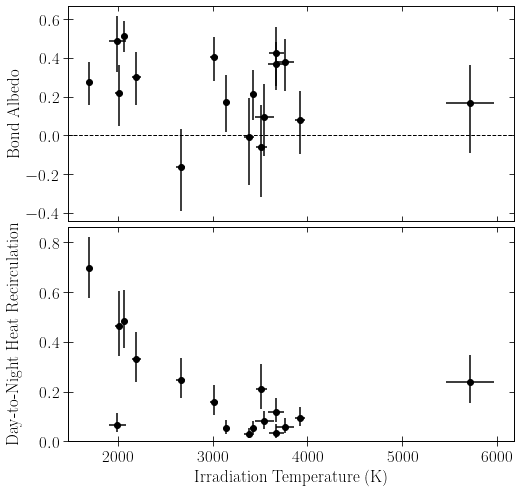

In [7]:
fig1 = make_SchwartzCowan_plot(planets, channels, literature=True, twoD=False, passUncert=True)

HD189733b
1692.7783014076313 0.38986805480952713 0.5387329252926635

WASP-43b
1993.7093569229032 0.5275917424012513 0.09885171860846238

Qatar-1b
2011.1917146213354 0.3706358395349322 0.17434895108192025

HD209458b
2064.518525750988 0.4346385706596121 0.5493218202319283

CoRoT-2b
2192.8275037148305 0.28362292411634327 0.13338430966525472

WASP-14b
2660.3790701953367 -0.1603610019934164 0.23238069796314534

WASP-19b
3003.1978868755627 0.3831151101760689 0.22863558183095908

HAT-P-7b
3136.356007124361 -1.1421917955357561 0.7186324114746432

WASP-18b
3389.1642355821255 -0.1206617646981385 0.02637312414159365

KELT-1b
3436.471927720383 -0.3482101262105929 0.06392942102373461

KELT-16b
3503.4679181741017 -0.16105255172924982 0.30649416211991803

WASP-103b
3535.125523715859 0.2506040017097565 0.025679854384093558

MASCARA-1b
3744.847847020733 0.3786668192725985 0.07505084589899554

WASP-12b
3669.122831794887 0.38995724892586214 0.03191600342132618

WASP-12b_old
3669.849664642239 0.2027190854

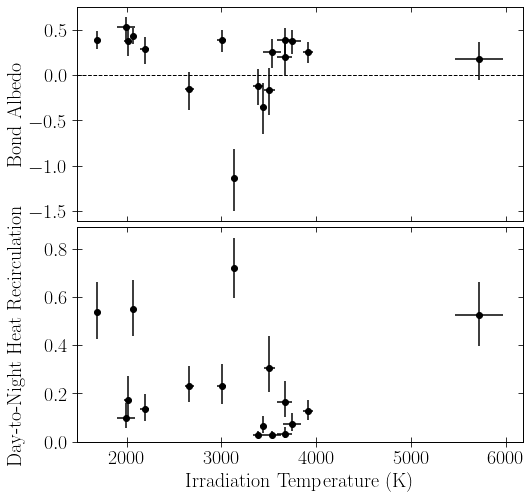

In [7]:
fig2 = make_SchwartzCowan_plot(planets, channels, literature=False, twoD=False)

HD189733b
Knutson+2012
1692.810858227798 0.27526237707707774 0.700852786281538

WASP-43b
Stevenson+2017
1992.373304276535 0.49124410628581605 0.06737778959704309

Qatar-1b
Keating+2020
2009.3547857801864 0.21846698319807056 0.4658769343464783

HD209458b
Zellem+2014
2064.4104191431666 0.5144245810606835 0.48156639674824664

CoRoT-2b
Dang+2018
2192.8359278704925 0.3011863413539564 0.3307886449683352

WASP-14b
Wong+2015
2660.4702549106514 -0.16160881981467246 0.2471966025396337

WASP-19b
Wong+2016
3016.2450385714196 0.40085982058523095 0.15808971726428755

HAT-P-7b
Wong+2016
3137.6635647698686 0.17443972510677574 0.05019169769101248

WASP-18b
Maxted+2013
3381.4300788360465 -0.01508626265524371 0.02848490480126576

KELT-1b
Beatty+2019
3424.7300733085804 0.21653804817104932 0.05306016007470113

KELT-16b
3507.80893007038 -0.05311386976948085 0.20740666180872958

WASP-103b
Kreidberg+2018
3545.3568787227455 0.09817446631682147 0.08024691303302105

MASCARA-1b
3761.038785141211 0.378865545809779

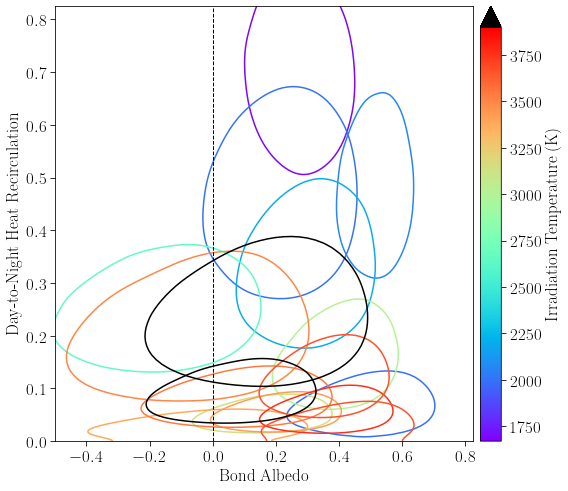

In [9]:
fig3 = make_SchwartzCowan_plot(planets, channels, literature=True, twoD=True)

HD189733b
1692.777590679402 0.3891323471012263 0.5378799729513972

WASP-43b
1993.5460460836189 0.5249227258102975 0.09981256291016641

Qatar-1b
2011.0710147923976 0.37135736510546613 0.17384324118651795

HD209458b
2064.4309122265913 0.43371185551355607 0.5502492306304552

CoRoT-2b
2193.103051633414 0.28371236634485403 0.1325836442898399

WASP-14b
2660.532633435595 -0.16014259943283282 0.2329085513833525

WASP-19b
3003.417099052264 0.38356658042442665 0.22878492592110017

HAT-P-7b
3136.4958167088434 -1.1490496484901573 0.7163044828290448

WASP-18b
3388.920338802185 -0.12190200875937895 0.02639478533045704

KELT-1b
3436.266612360058 -0.34161590688908894 0.06468489273084463

KELT-16b
3503.604522741293 -0.15605841663680264 0.3014732484785957

WASP-103b
3534.722690711081 0.2502243913957475 0.025876676605749493

MASCARA-1b
3745.230290955302 0.3749577645169315 0.0743361573534626

WASP-12b
3668.71540259384 0.38846297171395006 0.031231362037633527

WASP-12b_old
3669.514584573973 0.2041048325711

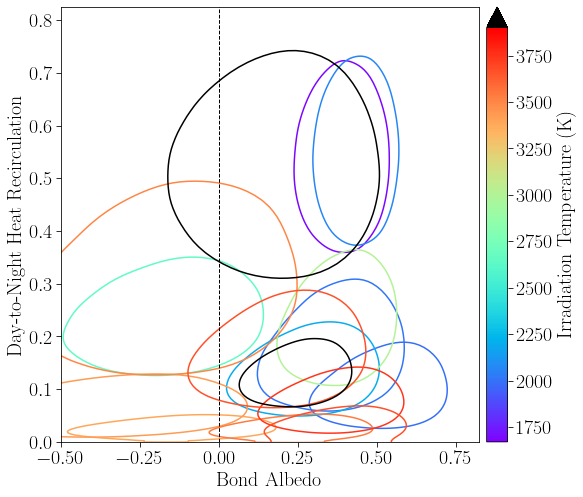

In [8]:
fig4 = make_SchwartzCowan_plot(planets, channels, literature=False, twoD=True)

In [11]:
fig1.savefig(mainpath+'figures/literature_1D_SchwartzReplica.pdf', bbox_inches='tight')
fig3.savefig(mainpath+'figures/literature_SchwartzReplica.pdf', bbox_inches='tight')

In [9]:
fig2.savefig(mainpath+'figures/reanalysis_1D_SchwartzReplica.pdf', bbox_inches='tight')
fig4.savefig(mainpath+'figures/reanalysis_SchwartzReplica.pdf', bbox_inches='tight')

In [10]:
archiveData = Table.to_pandas(Table.read('../masterfile.ecsv'))
names = np.array(archiveData['pl_hostname'])+np.array(archiveData['pl_letter'])
names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

In [11]:
plotData = []

for i in tqdm(range(len(planets))):
    channel = channels[i]
    planet = planets[i]
        
    # Figure out where files are saved
    phoption = ''
    foldername = ''
    rms = None
    with open(f'{mainpath}{planet}/analysis/{channel}/bestPhOption.txt') as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if phoption=='' and lines[i][0]=='/':
            foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
            phoption = lines[i].split('/')[-1].strip()
            i += 1
            ignoreFrames = np.array(lines[i].strip().split('=')[1].strip().replace(' ','').split(','))
            if np.all(ignoreFrames==['']):
                ignoreFrames = np.array([]).astype(int)
            else:
                ignoreFrames = ignoreFrames.astype(int)
            i += 1
            rms = float(lines[i])
        elif phoption!='' and lines[i][0]=='/':
            if float(lines[i+2]) < rms:
                foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                phoption = lines[i].split('/')[-1].strip()
                i += 1
                ignoreFrames = np.array(lines[i].split('=')[1].strip().replace(' ','').split(','))
                if np.all(ignoreFrames==['']):
                    ignoreFrames = np.array([]).astype(int)
                else:
                    ignoreFrames = ignoreFrames.astype(int)
                i += 1
                rms = float(lines[i])
            else:
                i += 3
    pldFoldernames = np.array(['/'.join(foldername.split('/')[:-2])+'/'+np.array(x)[0].split('/')[-1]+'/' for x in os.walk('/'.join(foldername.split('/')[:-2])+'/') if '4umPLD' in x[0].split('/')[-1] or '3umPLD' in x[0].split('/')[-1]])

    # Figure out what modes were run
    modes = np.sort([x[0].split('/')[-1] for x in os.walk(foldername)][1:])
    for i in range(len(pldFoldernames)):
        modes = np.append(modes, np.sort([x[0].split('/')[-1] for x in os.walk(pldFoldernames[i])][1:]))

    # Get rid of PSFX runs
    modes = np.array([mode for mode in modes if 'psfx' not in mode.lower()])

    # Get rid of older BLISS runs
    modes = np.array([mode for mode in modes if 'bliss' not in mode.lower() or 'finalpoet' in mode.lower()])
        
    #find the best mode
    bestBIC = np.inf
    ResultMCMC = []
    nData = 0
    for mode in modes:
        if 'PLD' in mode:
            if channel=='ch2':
                folder='4um'
            else:
                folder='3um'
            if '3x3' in mode:
                folder += 'PLD_3x3/'
            else:
                folder += 'PLD_5x5/'
            savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
        else:
            savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'

        if not os.path.exists(savepath):
            continue

        ResultMCMC_temp = np.load(savepath)
        BIC = -2*ResultMCMC_temp['evidenceB'][0]
        if BIC<bestBIC:
            bestBIC = BIC
            ResultMCMC = ResultMCMC_temp
            nData = ResultMCMC['chi2B'][0]/ResultMCMC['chi2datum'][0]

    if bestBIC==np.inf:
        continue #no analyses for this planet
    
    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    mass = [archiveData['pl_massj'][nameIndex], np.mean([archiveData['pl_massjerr1'][nameIndex],
                                                         np.abs(archiveData['pl_massjerr2'][nameIndex])])]
    density = [archiveData['pl_dens'][nameIndex], np.mean([archiveData['pl_denserr1'][nameIndex],
                                                           np.abs(archiveData['pl_denserr2'][nameIndex])])]
    period = [archiveData['pl_orbper'][nameIndex], np.mean([archiveData['pl_orbpererr1'][nameIndex],
                                                            np.abs(archiveData['pl_orbpererr2'][nameIndex])])]
    
    feh = [archiveData['st_metfe'][nameIndex], np.mean([archiveData['st_metfeerr1'][nameIndex],
                                                        np.abs(archiveData['st_metfeerr2'][nameIndex])])]
    
    Tstar = [archiveData['st_teff'][nameIndex], np.mean([archiveData['st_tefferr1'][nameIndex],
                                                         np.abs(archiveData['st_tefferr2'][nameIndex])])]
    
    Rstar = [archiveData['st_rad'][nameIndex], np.mean([archiveData['st_raderr1'][nameIndex],
                                                       np.abs(archiveData['st_raderr2'][nameIndex])])]

    if planet=='KELT-1b':
        Tstar = [6518, 50]
        Rstar = [1.462, 0.037]
        feh = [0.052,0.079]
    elif planet=='WASP-33b':
        feh = [0.10,0.]
    elif planet=='MASCARA-1b':
        feh = [0,0]
    
    if np.all(np.isnan(ResultMCMC['fp'])):
        continue
    
    newTb = recompute_Tb(ResultMCMC['fp'], ResultMCMC['rp'], ResultMCMC['A'],
                         planet, channel, mainpath)
    Tday = newTb[[0,1,2]]
    Tnight = newTb[[3,4,5]]
    
    n = int(1.5e5)    
    Tstar = np.random.normal(Tstar[0],  Tstar[1], n)
    a_down = np.random.normal(ResultMCMC['a'][0], ResultMCMC['a'][2], n)
    a_up = np.random.normal(ResultMCMC['a'][0], ResultMCMC['a'][1], n)
    a = np.append(a_down[a_down<ResultMCMC['a'][0]], a_up[a_up>=ResultMCMC['a'][0]])
    
    # Update day and nightside uncertainties using Pass+2019
    bands = np.array([4.493e-6])  # central wavelengths of observed bands (m)
    td_brights = np.array([Tday[0]])  # brightness temperatures in these bands (K)
    td_uncs = np.array([np.mean(Tday[1:])])  # uncertainties on brightness temperatures (K)
    tn_brights = np.array([Tnight[0]])  # brightness temperatures in these bands (K)
    tn_uncs = np.array([np.mean(Tnight[1:])])  # uncertainties on brightness temperatures (K)

    Tday = np.array(pass_uncerts(bands, td_brights, td_uncs))
    Tnight = np.array(pass_uncerts(bands, tn_brights, tn_uncs))

    Td = np.random.normal(Tday[0], Tday[1], n)
    Tn = np.random.normal(Tnight[0], Tday[1], n)
    
    n = np.min([Td.size, Tn.size, Tstar.size, a.size])
    Td = Td[np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][:n]
    Tn = Tn[np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][:n]
    a = a[np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][:n]
    Tstar = Tstar[:n]
    
    T0 = Tstar*np.sqrt(1/a)
    
    eps = 8/(5+3*(Td/Tn)**4) 
    AB = 1-(5*Tn**4+3*Td**4)/(2*T0**4)
    
    Tstar = np.append([np.median(Tstar)], np.mean(np.abs(np.percentile(Tstar, [16, 84])-np.median(Tstar))))
    T0 = np.append([np.median(T0)], np.mean(np.abs(np.percentile(T0, [16, 84])-np.median(T0))))
    eps = np.append([np.median(eps)], np.mean(np.abs(np.percentile(eps, [16, 84])-np.median(eps))))
    AB = np.append([np.median(AB)], np.mean(np.abs(np.percentile(AB, [16, 84])-np.median(AB))))
    
    A = ResultMCMC['A']
    B = ResultMCMC['B']
    
    phi = np.linspace(0,2*np.pi,10000)
    A_MC = np.random.normal(ResultMCMC['A'][0], np.mean(ResultMCMC['A'][1:]), 1000)[:,np.newaxis]
    B_MC = np.random.normal(ResultMCMC['B'][0], np.mean(ResultMCMC['B'][1:]), 1000)[:,np.newaxis]
    fp_MC = np.random.normal(ResultMCMC['fp'][0], np.mean(ResultMCMC['fp'][1:]), 1000)[:,np.newaxis]*1e6
    pc = 1. + A_MC*(np.cos(phi)-1.) + B_MC*np.sin(phi)
    if 'D' in ResultMCMC.dtype.names and 'WASP-12b' not in planet:
        C_MC = np.random.normal(ResultMCMC['C'][0], np.mean(ResultMCMC['C'][1:]), 1000)[:,np.newaxis]
        D_MC = np.random.normal(ResultMCMC['D'][0], np.mean(ResultMCMC['D'][1:]), 1000)[:,np.newaxis]
        pc += C_MC*(np.cos(2.*phi)-1.) + D_MC*np.sin(2.*phi)
#     pc *= fp_MC
    amp_MC = (np.max(pc, axis=1)-np.min(pc, axis=1))
    amp = np.array([np.median(amp_MC), *np.abs(np.percentile(amp_MC, [84, 16])-np.median(amp_MC))])
    amp = np.array([amp[0], np.mean(np.abs(amp[1:]))])
    
    A = np.array([A[0], np.mean(np.abs(A[1:]))])
    
    if planet != 'WASP-12b' and planet!='WASP-12b_old':
        offset = np.array([ResultMCMC['offset'][0], np.mean(np.abs(ResultMCMC['offset'][1:]))])
    else:
        tempOffset = np.array([-np.arctan2(ResultMCMC['B'][0], ResultMCMC['A'][0]),])
        tempOffset = np.append(tempOffset, np.sqrt(((ResultMCMC['A'][0]*np.mean(ResultMCMC['B'][1:]))**2+(np.mean(ResultMCMC['A'][1:])*ResultMCMC['B'][0])**2))/(ResultMCMC['A'][0]**2+ResultMCMC['B'][0]**2))
        offset = tempOffset*180/np.pi
    rp_rs = ResultMCMC['rp']
    rp_rs = np.array([rp_rs[0], np.mean(np.abs(rp_rs[1:]))])
    logMass = np.log(mass)
    
    rp_rs_sim = np.random.normal(rp_rs[0], rp_rs[1], int(1e5))
    rs_sim = np.random.normal(Rstar[0], Rstar[1], int(1e5))
    mass_sim = np.random.normal(mass[0], mass[1], int(1e5))
    rp_sim = rp_rs_sim*rs_sim*const.R_sun.value/const.R_jup.value
    rp = [np.median(rp_sim), np.mean(np.abs(np.percentile(rp_sim, [16, 84])-np.median(rp_sim)))]
    
    logg_pl_sim = np.log(const.G.value*mass_sim*const.M_jup.value/((rp_sim*const.R_jup.value)**2))
    logg_pl = [np.nanmedian(logg_pl_sim), np.nanmean(np.abs(np.nanpercentile(logg_pl_sim, [16, 84])-np.nanmedian(logg_pl_sim)))]
    
    plotData.append([Tstar, T0, Tday, Tnight, A, offset, eps, AB, rp, mass, logMass, density, logg_pl, period, feh, amp])
    
plotData = np.array(plotData)

100%|██████████| 17/17 [02:41<00:00,  9.51s/it]


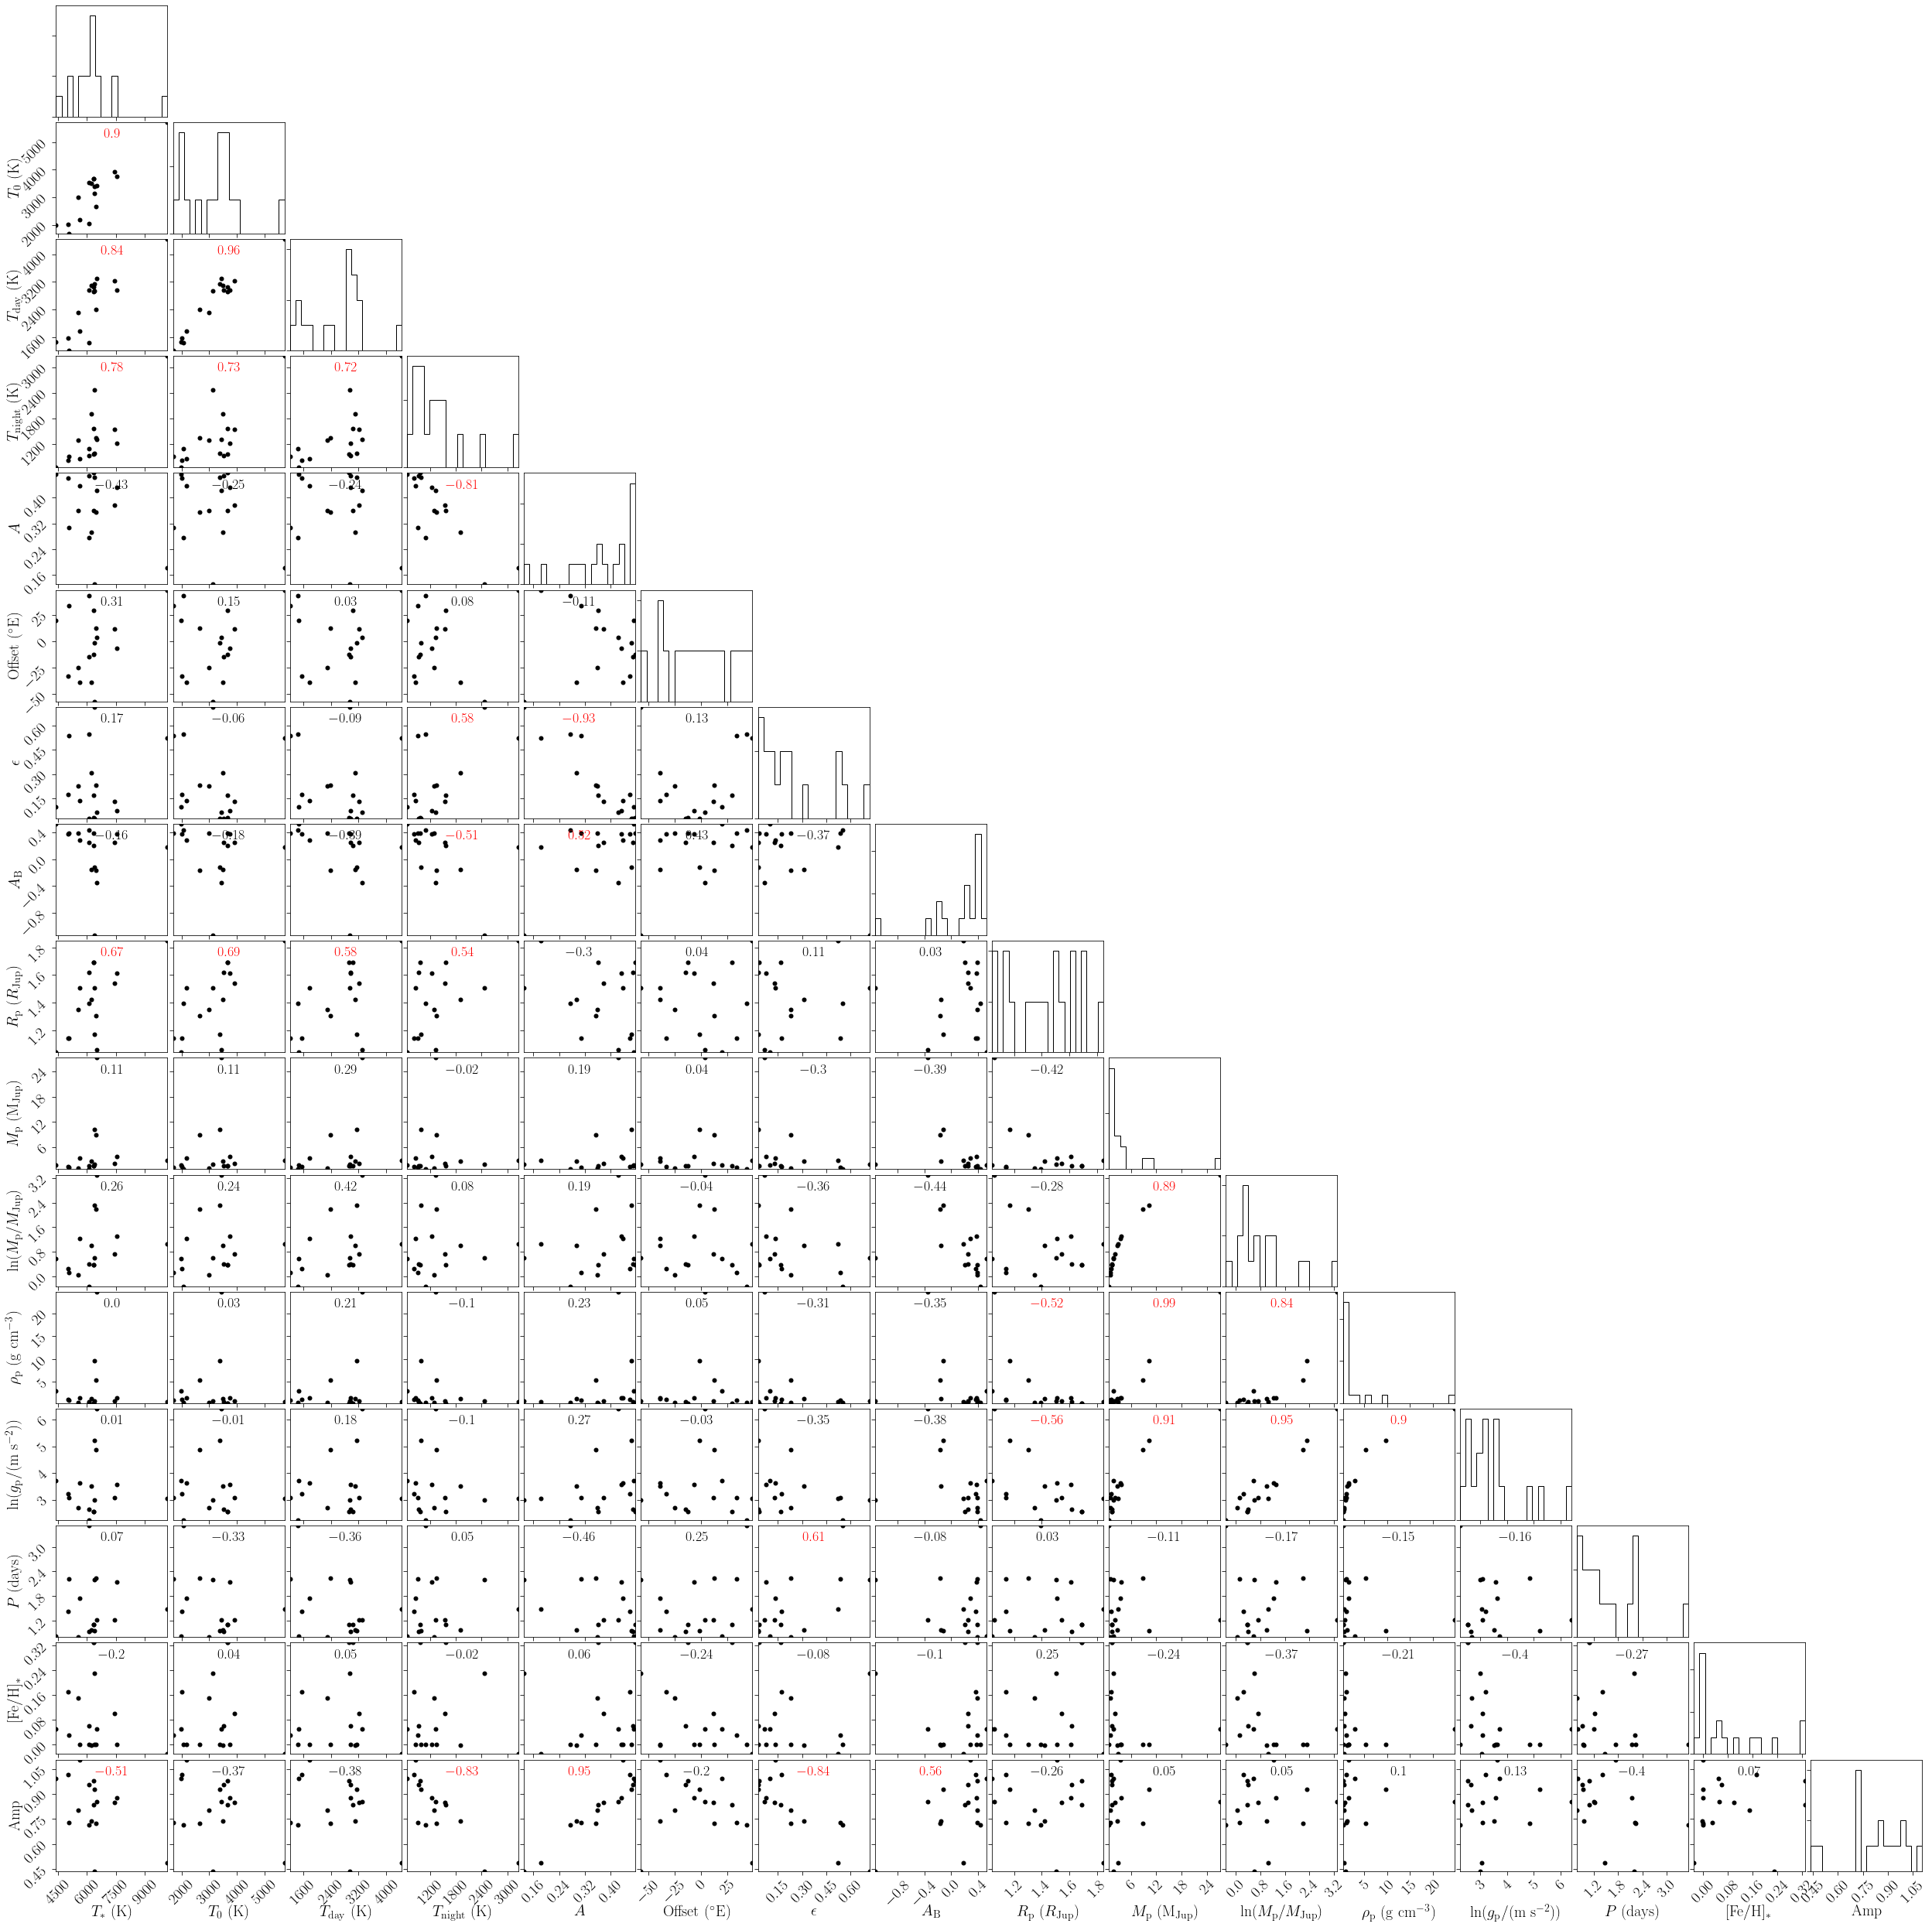

In [12]:
labels=[r'$T_{\rm *}~\rm (K)$', r'$T_{\rm 0}~\rm (K)$', r'$T_{\rm day}~\rm (K)$', r'$T_{\rm night}~\rm (K)$',
        r'$A$', r'$\rm Offset~\rm (^{\circ}E)$', r'$\epsilon$', r'$A_{\rm B}$',
        r'$R_{\rm p}~(R_{\rm Jup})$', r'$M_{\rm p}~\rm (M_{\rm Jup})$', r'$\ln(M_{\rm p}/M_{\rm Jup})$',
        r'$\rho_{\rm p}~\rm (g~cm^{-3})$', r'$\ln(g_{\rm p} / ({\rm m~s^{-2}}))$', r'$P~\rm (days)$',
        r'$\rm [Fe/H]_{\rm *}$', r'$\rm Amp$']

corner.corner(plotData[:,:,0], labels=labels,
       plot_datapoints=True, plot_density=False, plot_contours=False, data_kwargs={'ms':6, 'alpha':1, 'color':'k'})
figure = plt.gcf()

axes = np.array(figure.get_axes()).reshape(plotData.shape[1], plotData.shape[1])
for indX, x in enumerate(plotData[:,:,0].T):
    nameX = labels[indX]
    for indY, y in enumerate(plotData[:,(indX+1):,0].T):
        nameY = labels[(indX+1):][indY]
        r = pearsonr(x,y)
        axes[indY+indX+1, indX].text(0.5, 0.95, '$'+str(np.round(r[0], 2))+'$', horizontalalignment='center', verticalalignment='top', transform=axes[indY+indX+1, indX].transAxes, color=['black', 'red'][int(r[1]<0.05)], fontsize=18)

figure.patch.set_facecolor('white')
        
figure.savefig(mainpath+'figures/populationCorrelations_corner.pdf', bbox_inches='tight')
figure.savefig(mainpath+'figures/populationCorrelations_corner.png', dpi=300, bbox_inches='tight')
# plt.show()

In [13]:
print(planets[np.isin(planets,['KELT-16b', 'MASCARA-1b'])])
print(plotData[np.isin(planets,['KELT-16b', 'MASCARA-1b']),np.array(labels)==r'$A_{\rm B}$',:])

['KELT-16b' 'MASCARA-1b']
[[-0.15755265  0.26230526]
 [ 0.37644186  0.13812686]]


In [14]:
print(planets[np.isin(planets,['KELT-16b', 'MASCARA-1b'])])
print(plotData[np.isin(planets,['KELT-16b', 'MASCARA-1b']),np.array(labels)==r'$\epsilon$',:])

['KELT-16b' 'MASCARA-1b']
[[0.30914831 0.11842892]
 [0.07386587 0.03795264]]


1
(0.8966037027823149, 1.100591502220949e-06)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    -5478.1 +/-     1774.3          Guessed: -1283.6   
   p[1] =     1.3093 +/-    0.29883          Guessed: 0.69756   


100%|██████████| 10001/10001 [00:05<00:00, 1811.69it/s]


**** MC uncertainty finding has finished
   p[0] =    -5478.1 +/-     202.97          Guessed: -1283.6   
   p[0] Bias : -8.299e-06 +/- 0.004059  (  -0.00 SD)
   p[1] =     1.3093 +/-   0.034035          Guessed: 0.69756   
   p[1] Bias : -2.379e-05 +/- 0.002861  (  -0.01 SD)


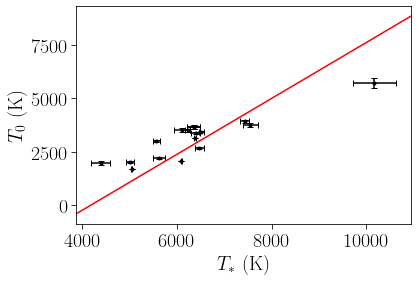

2
(0.8369018175682803, 2.8029852279281108e-05)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    -2934.6 +/-     1018.8          Guessed: -994.87   
   p[1] =    0.84427 +/-    0.17183          Guessed: 0.56747   


100%|██████████| 10001/10001 [00:04<00:00, 2346.23it/s]


**** MC uncertainty finding has finished
   p[0] =    -2940.1 +/-     310.07          Guessed: -994.87   
   p[0] Bias : +0.001889 +/- 0.004351  (   0.43 SD)
   p[1] =    0.84503 +/-   0.051732          Guessed: 0.56747   
   p[1] Bias : +0.0008969 +/- 0.002551  (   0.35 SD)


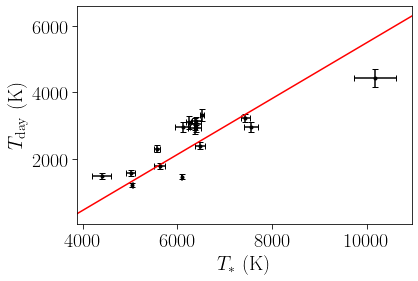

3
(0.7812625574957643, 0.00021311433564641602)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    -912.08 +/-     318.96          Guessed: -1224.3   
   p[1] =    0.34282 +/-   0.053656          Guessed: 0.40795   


100%|██████████| 10001/10001 [00:03<00:00, 2507.60it/s]


**** MC uncertainty finding has finished
   p[0] =    -911.39 +/-     166.88          Guessed: -1224.3   
   p[0] Bias : -0.0007602 +/- 0.004383  (  -0.17 SD)
   p[1] =    0.34284 +/-   0.028131          Guessed: 0.40795   
   p[1] Bias : +5.062e-05 +/- 0.001962  (   0.03 SD)


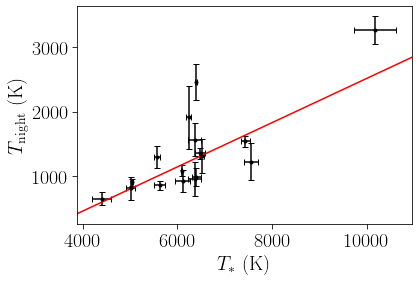

4
(0.6746353833937271, 0.002971211908178235)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =      0.307 +/-    0.24272          Guessed: 0.59137   
   p[1] = 0.00016953 +/- 4.2068e-05          Guessed: 0.00012965


100%|██████████| 10001/10001 [00:04<00:00, 2193.84it/s]


**** MC uncertainty finding has finished
   p[0] =    0.30777 +/-   0.070997          Guessed: 0.59137   
   p[0] Bias : +0.002508 +/- 0.009909  (   0.25 SD)
   p[1] = 0.00016941 +/- 1.2341e-05          Guessed: 0.00012965
   p[1] Bias : -0.0006962 +/- 0.00311   (  -0.22 SD)


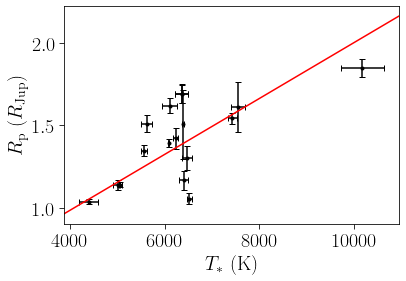

5
(-0.5149066093680132, 0.034425260627498275)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     1.3058 +/-     0.1514          Guessed: 1.2791    
   p[1] = -6.7662e-05 +/- 2.1966e-05          Guessed: -7.1796e-05


100%|██████████| 10001/10001 [00:05<00:00, 1850.65it/s]


**** MC uncertainty finding has finished
   p[0] =     1.3052 +/-   0.048811          Guessed: 1.2791    
   p[0] Bias : -0.0004337 +/- 0.001453  (  -0.30 SD)
   p[1] = -6.7636e-05 +/- 7.1393e-06          Guessed: -7.1796e-05
   p[1] Bias : -0.0003768 +/- 0.004069  (  -0.09 SD)


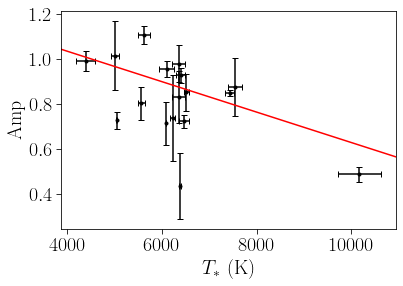

6
(0.9647402209568765, 4.214566631505927e-10)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    -406.03 +/-     143.99          Guessed: -36.297   
   p[1] =    0.96419 +/-   0.055027          Guessed: 0.8408    


100%|██████████| 10001/10001 [00:03<00:00, 2958.70it/s]


**** MC uncertainty finding has finished
   p[0] =     -406.4 +/-     100.34          Guessed: -36.297   
   p[0] Bias : +0.0008958 +/- 0.004445  (   0.20 SD)
   p[1] =    0.96431 +/-   0.038547          Guessed: 0.8408    
   p[1] Bias : +0.0001242 +/- 0.0007153 (   0.17 SD)


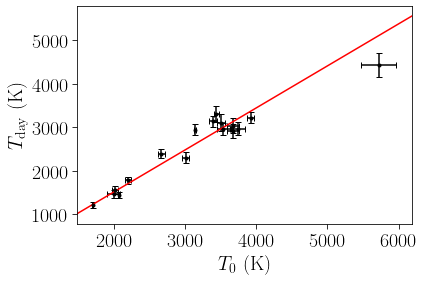

7
(0.729557753131695, 0.000887875507162107)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     178.76 +/-     196.85          Guessed: -174.98   
   p[1] =    0.36719 +/-   0.074306          Guessed: 0.48966   


100%|██████████| 10001/10001 [00:03<00:00, 2602.16it/s]


**** MC uncertainty finding has finished
   p[0] =     179.26 +/-     83.088          Guessed: -174.98   
   p[0] Bias : +0.002804 +/- 0.0138    (   0.20 SD)
   p[1] =     0.3672 +/-   0.031361          Guessed: 0.48966   
   p[1] Bias : +3.601e-05 +/- 0.002536  (   0.01 SD)


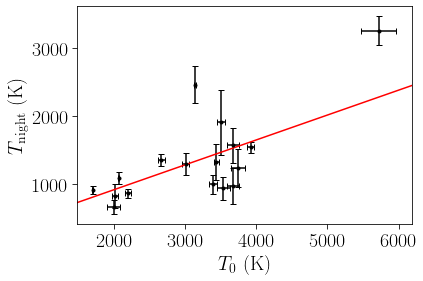

8
(0.6930811339047608, 0.002037597034995825)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.84211 +/-    0.11067          Guessed: 0.87596   
   p[1] = 0.00017151 +/- 4.3216e-05          Guessed: 0.00017121


100%|██████████| 10001/10001 [00:04<00:00, 2390.27it/s]


**** MC uncertainty finding has finished
   p[0] =    0.84238 +/-   0.022046          Guessed: 0.87596   
   p[0] Bias : +0.0003295 +/- 0.001647  (   0.20 SD)
   p[1] = 0.00017138 +/- 8.8716e-06          Guessed: 0.00017121
   p[1] Bias : -0.0008071 +/- 0.003158  (  -0.26 SD)


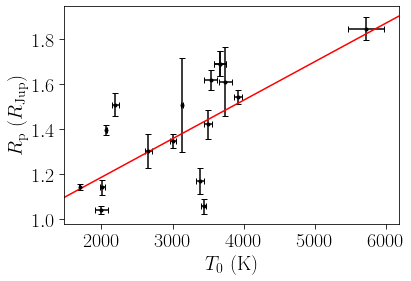

9
(0.715746360782187, 0.0012337916388439718)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     268.55 +/-     194.05          Guessed: -72.745   
   p[1] =    0.41302 +/-   0.090174          Guessed: 0.5512    


100%|██████████| 10001/10001 [00:04<00:00, 2096.11it/s]


**** MC uncertainty finding has finished
   p[0] =     269.43 +/-     88.915          Guessed: -72.745   
   p[0] Bias : +0.003275 +/- 0.009057  (   0.36 SD)
   p[1] =    0.41253 +/-   0.041731          Guessed: 0.5512    
   p[1] Bias : -0.001171 +/- 0.002736  (  -0.43 SD)


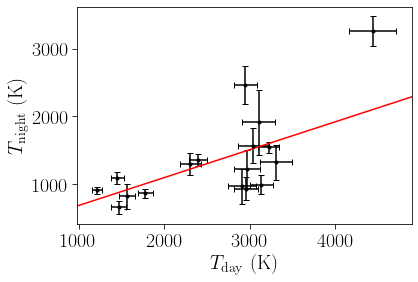

10
(0.5809451592282335, 0.01446357700060852)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.78757 +/-    0.12651          Guessed: 0.98472   
   p[1] = 0.00025307 +/- 6.2587e-05          Guessed: 0.00016466


100%|██████████| 10001/10001 [00:06<00:00, 1584.50it/s]


**** MC uncertainty finding has finished
   p[0] =    0.78776 +/-   0.036808          Guessed: 0.98472   
   p[0] Bias : +0.0002331 +/- 0.002013  (   0.12 SD)
   p[1] = 0.00025328 +/- 1.9412e-05          Guessed: 0.00016466
   p[1] Bias : +0.0008453 +/- 0.0031    (   0.27 SD)


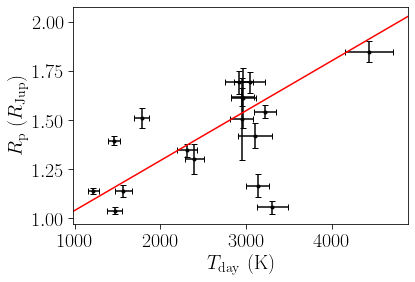

11
(-0.8121523772301519, 7.492508870313385e-05)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.53143 +/-   0.030694          Guessed: 0.5418    
   p[1] = -0.00011345 +/- 2.3189e-05          Guessed: -0.00012667


100%|██████████| 10001/10001 [00:05<00:00, 1915.85it/s]


**** MC uncertainty finding has finished
   p[0] =    0.53187 +/-   0.017289          Guessed: 0.5418    
   p[0] Bias : +0.0008354 +/- 0.0007239 (   1.15 SD)
   p[1] = -0.0001136 +/-  1.455e-05          Guessed: -0.00012667
   p[1] Bias : +0.001317 +/- 0.002562  (   0.51 SD)


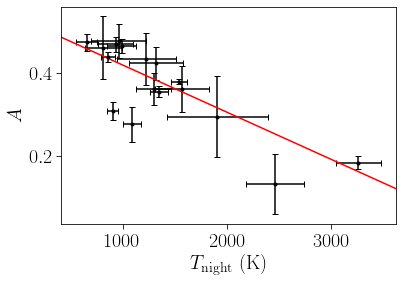

12
(0.5765588000325363, 0.015404219183992558)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =   -0.16633 +/-   0.084743          Guessed: -0.018918 
   p[1] = 0.00025589 +/- 7.4393e-05          Guessed: 0.0001874 


100%|██████████| 10001/10001 [00:06<00:00, 1464.65it/s]


**** MC uncertainty finding has finished
   p[0] =   -0.16504 +/-   0.040127          Guessed: -0.018918 
   p[0] Bias : -0.007735 +/- 0.006386  (  -1.21 SD)
   p[1] = 0.00025523 +/- 4.1304e-05          Guessed: 0.0001874 
   p[1] Bias : -0.002574 +/- 0.003644  (  -0.71 SD)


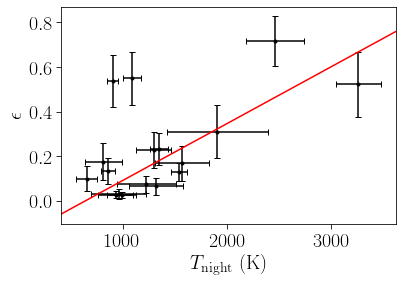

13
(-0.5054591417234617, 0.03847160138749031)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.65173 +/-    0.15202          Guessed: 0.55056   
   p[1] = -0.00030936 +/- 0.00012144          Guessed: -0.00031309


100%|██████████| 10001/10001 [00:05<00:00, 1685.53it/s]


**** MC uncertainty finding has finished
   p[0] =    0.64992 +/-    0.12984          Guessed: 0.55056   
   p[0] Bias : -0.002776 +/- 0.002924  (  -0.95 SD)
   p[1] = -0.00030928 +/- 0.00010853          Guessed: -0.00031309
   p[1] Bias : -0.0002336 +/- 0.00492   (  -0.05 SD)


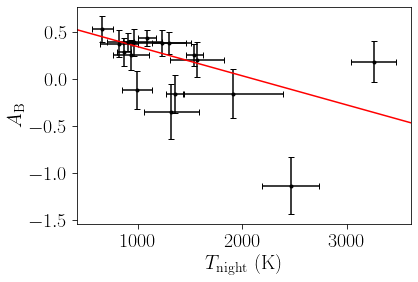

14
(0.5378922809470865, 0.025937656953165515)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.70274 +/-    0.15197          Guessed: 1.1436    
   p[1] = 0.00055597 +/- 0.00013466          Guessed: 0.00019797


100%|██████████| 10001/10001 [00:06<00:00, 1578.93it/s]


**** MC uncertainty finding has finished
   p[0] =     0.7017 +/-   0.070681          Guessed: 1.1436    
   p[0] Bias : -0.001482 +/- 0.002711  (  -0.55 SD)
   p[1] = 0.00055768 +/- 6.5442e-05          Guessed: 0.00019797
   p[1] Bias : +0.00307  +/- 0.003036  (   1.01 SD)


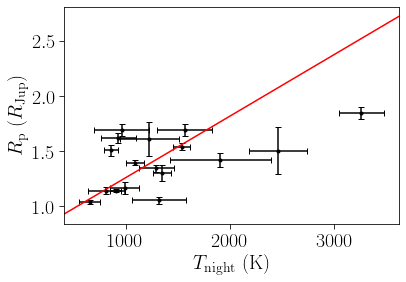

15
(-0.8292914310237176, 3.854833880663345e-05)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     1.1321 +/-   0.070444          Guessed: 1.1255    
   p[1] = -0.00021733 +/- 5.1615e-05          Guessed: -0.00022144


100%|██████████| 10001/10001 [00:05<00:00, 1832.91it/s]


**** MC uncertainty finding has finished
   p[0] =     1.1321 +/-   0.044267          Guessed: 1.1255    
   p[0] Bias : +1.536e-05 +/- 0.0007799 (   0.02 SD)
   p[1] = -0.00021679 +/- 3.6178e-05          Guessed: -0.00022144
   p[1] Bias : -0.002518 +/- 0.002977  (  -0.85 SD)


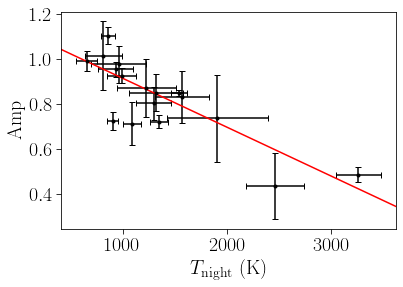

16
(-0.9276852484076592, 8.2637762744662e-08)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.93979 +/-    0.11628          Guessed: 0.95026   
   p[1] =    -1.9565 +/-    0.27116          Guessed: -1.9332   


100%|██████████| 10001/10001 [00:04<00:00, 2031.85it/s]


**** MC uncertainty finding has finished
   p[0] =    0.93968 +/-    0.12286          Guessed: 0.95026   
   p[0] Bias : -0.0001161 +/- 0.001551  (  -0.07 SD)
   p[1] =    -1.9535 +/-    0.28832          Guessed: -1.9332   
   p[1] Bias : -0.001573 +/- 0.001737  (  -0.91 SD)


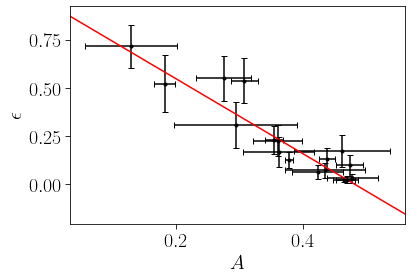

17
(0.5186720968585131, 0.03290650058194406)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =   -0.19557 +/-     0.3179          Guessed: -0.63648  
   p[1] =     1.2793 +/-     0.8174          Guessed: 2.0598    


100%|██████████| 10001/10001 [00:09<00:00, 1035.82it/s]


**** MC uncertainty finding has finished
   p[0] =   -0.17981 +/-    0.40918          Guessed: -0.63648  
   p[0] Bias : -0.08058  +/- 0.02037   (  -3.96 SD)
   p[1] =       1.24 +/-     1.0583          Guessed: 2.0598    
   p[1] Bias : -0.03069  +/- 0.008008  (  -3.83 SD)


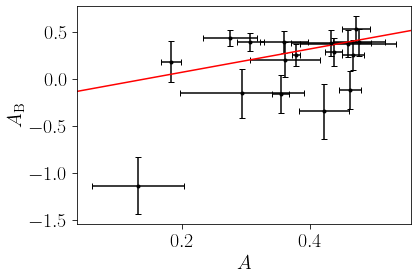

18
(0.9467725023552016, 8.777883375186119e-09)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.12786 +/-   0.077045          Guessed: 0.22538   
   p[1] =     1.8842 +/-    0.20115          Guessed: 1.6209    


100%|██████████| 10001/10001 [00:04<00:00, 2063.75it/s]


**** MC uncertainty finding has finished
   p[0] =    0.12673 +/-   0.074631          Guessed: 0.22538   
   p[0] Bias : -0.008889 +/- 0.007552  (  -1.18 SD)
   p[1] =     1.8886 +/-     0.1968          Guessed: 1.6209    
   p[1] Bias : +0.002358 +/- 0.001338  (   1.76 SD)


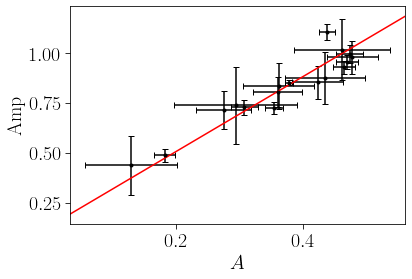

19
(0.613966836362984, 0.008746710897794644)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.69629 +/-    0.18543          Guessed: 1.0405    
   p[1] =     6.9313 +/-     2.2877          Guessed: 2.0805    


100%|██████████| 10001/10001 [00:20<00:00, 498.18it/s]


**** MC uncertainty finding has finished
   p[0] =    0.88031 +/-    0.11766          Guessed: 1.0405    
   p[0] Bias : +0.2643   +/- 0.003338  (  79.18 SD)
   p[1] =     3.8139 +/-     1.6378          Guessed: 2.0805    
   p[1] Bias : -0.4497   +/- 0.004137  (-108.72 SD)


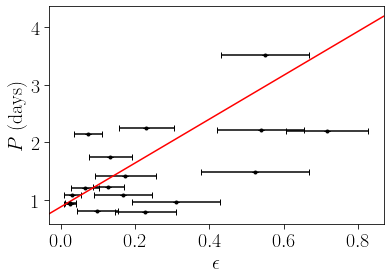

20
(-0.8388694501699345, 2.574592187304196e-05)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     1.0007 +/-   0.028832          Guessed: 0.98683   
   p[1] =   -0.89808 +/-    0.17336          Guessed: -0.68915  


100%|██████████| 10001/10001 [00:07<00:00, 1399.55it/s]


**** MC uncertainty finding has finished
   p[0] =     1.0008 +/-    0.02165          Guessed: 0.98683   
   p[0] Bias : +0.0001119 +/- 0.0003611 (   0.31 SD)
   p[1] =    -0.8986 +/-    0.14743          Guessed: -0.68915  
   p[1] Bias : +0.0005725 +/- 0.002419  (   0.24 SD)


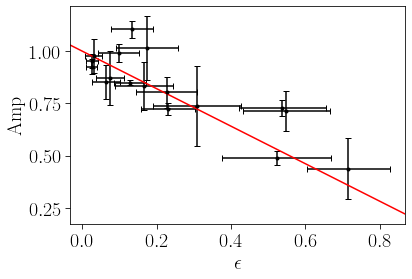

21
(0.56156740333087, 0.018987493344323515)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.59043 +/-    0.13137          Guessed: 0.79395   
   p[1] =    0.93482 +/-    0.40451          Guessed: 0.24208   


100%|██████████| 10001/10001 [00:13<00:00, 748.59it/s]


**** MC uncertainty finding has finished
   p[0] =    0.59085 +/-      3.203          Guessed: 0.79395   
   p[0] Bias : +0.0007229 +/- 0.002789  (   0.26 SD)
   p[1] =     0.9262 +/-     10.993          Guessed: 0.24208   
   p[1] Bias : -0.009215 +/- 0.005424  (  -1.70 SD)


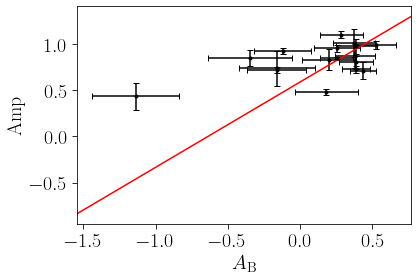

22
(-0.5232036475314029, 0.03114739586874624)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     4.0518 +/-     1.5603          Guessed: 21.437    
   p[1] =    -2.4248 +/-     1.1009          Guessed: -12.978   


100%|██████████| 10001/10001 [00:06<00:00, 1438.95it/s]


**** MC uncertainty finding has finished
   p[0] =     4.0504 +/-    0.35965          Guessed: 21.437    
   p[0] Bias : -0.000347 +/- 0.004826  (  -0.07 SD)
   p[1] =    -2.4227 +/-    0.25201          Guessed: -12.978   
   p[1] Bias : -0.000871 +/- 0.005691  (  -0.15 SD)


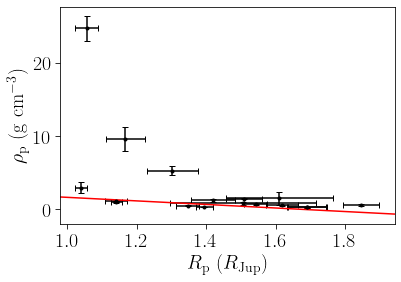

23
(-0.563486124762371, 0.018495642872483124)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =      11.55 +/-     2.6462          Guessed: 7.0303    
   p[1] =    -6.5061 +/-     2.1073          Guessed: -2.522    


100%|██████████| 10001/10001 [00:06<00:00, 1541.16it/s]


**** MC uncertainty finding has finished
   p[0] =     11.555 +/-    0.59227          Guessed: 7.0303    
   p[0] Bias : +0.0004309 +/- 0.002871  (   0.15 SD)
   p[1] =    -6.5115 +/-    0.48096          Guessed: -2.522    
   p[1] Bias : +0.0008224 +/- 0.00406   (   0.20 SD)


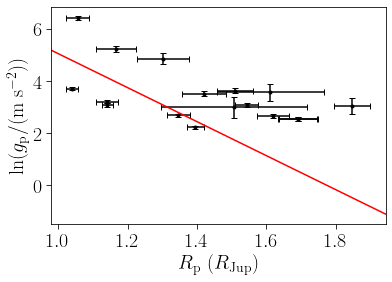

24
(0.8901058337444383, 1.7048693804201712e-06)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.82821 +/-    0.16323          Guessed: 0.36583   
   p[1] =    0.11866 +/-   0.025306          Guessed: 0.1284    


100%|██████████| 10001/10001 [00:03<00:00, 2500.56it/s]


**** MC uncertainty finding has finished
   p[0] =    0.83043 +/-    0.16762          Guessed: 0.36583   
   p[0] Bias : +0.002671 +/- 0.00247   (   1.08 SD)
   p[1] =    0.11909 +/-    0.02535          Guessed: 0.1284    
   p[1] Bias : +0.003551 +/- 0.002673  (   1.33 SD)


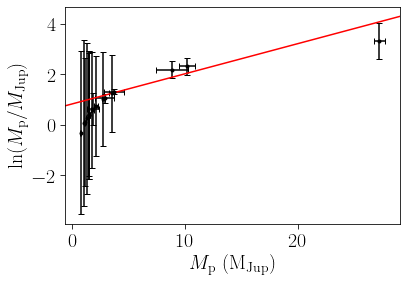

25
(0.9867369900464851, 2.9352133696906936e-13)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =   -0.44381 +/-    0.23128          Guessed: -0.88818  
   p[1] =    0.82666 +/-    0.18989          Guessed: 0.92263   


100%|██████████| 10001/10001 [00:06<00:00, 1579.50it/s]


**** MC uncertainty finding has finished
   p[0] =   -0.44297 +/-   0.077461          Guessed: -0.88818  
   p[0] Bias : -0.001893 +/- 0.006532  (  -0.29 SD)
   p[1] =    0.82687 +/-   0.069474          Guessed: 0.92263   
   p[1] Bias : +0.00025  +/- 0.002879  (   0.09 SD)


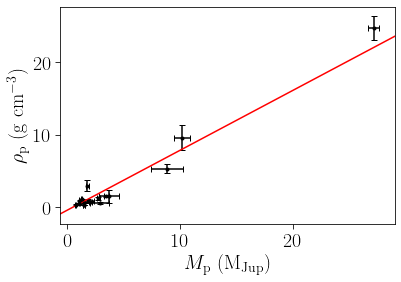

26
(0.9053800355652009, 5.808929183671355e-07)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     2.7236 +/-    0.12775          Guessed: 2.8066    
   p[1] =    0.14842 +/-   0.020016          Guessed: 0.15275   


100%|██████████| 10001/10001 [00:03<00:00, 2526.58it/s]


**** MC uncertainty finding has finished
   p[0] =     2.7237 +/-    0.02586          Guessed: 2.8066    
   p[0] Bias : +2.969e-05 +/- 0.0005879 (   0.05 SD)
   p[1] =    0.14839 +/-   0.004296          Guessed: 0.15275   
   p[1] Bias : -0.0001759 +/- 0.00169   (  -0.10 SD)


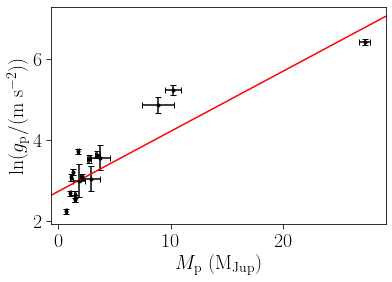

27
(0.8405663053129145, 2.3904761125516617e-05)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    -9.3729 +/-     2.8171          Guessed: -1.918    
   p[1] =      8.609 +/-     1.9378          Guessed: 5.4483    


100%|██████████| 10001/10001 [00:06<00:00, 1653.07it/s]


**** MC uncertainty finding has finished
   p[0] =    -9.3757 +/-     3.5673          Guessed: -1.918    
   p[0] Bias : +0.0003038 +/- 0.003767  (   0.08 SD)
   p[1] =     8.6144 +/-     2.4719          Guessed: 5.4483    
   p[1] Bias : +0.0006251 +/- 0.002821  (   0.22 SD)


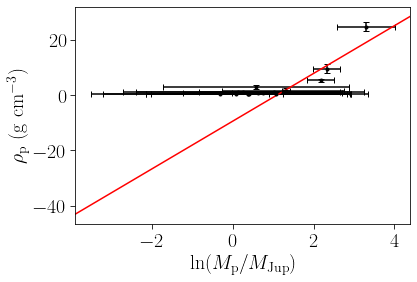

28
(0.9504831714508115, 5.161017206095803e-09)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     1.6007 +/-    0.55332          Guessed: 2.4432    
   p[1] =     1.5093 +/-    0.33108          Guessed: 1.1116    


100%|██████████| 10001/10001 [00:04<00:00, 2064.67it/s]


**** MC uncertainty finding has finished
   p[0] =     1.5933 +/-    0.73672          Guessed: 2.4432    
   p[0] Bias : -0.004624 +/- 0.004333  (  -1.07 SD)
   p[1] =     1.5076 +/-    0.46615          Guessed: 1.1116    
   p[1] Bias : -0.001128 +/- 0.002749  (  -0.41 SD)


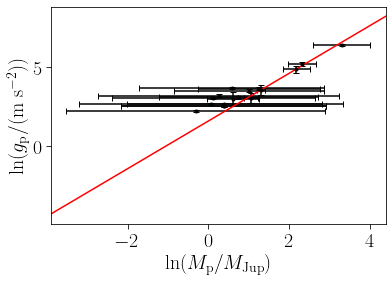

29
(0.8958797677874225, 1.1572071488568484e-06)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     2.3702 +/-    0.16706          Guessed: 2.9658    
   p[1] =    0.64322 +/-     0.1956          Guessed: 0.16165   


100%|██████████| 10001/10001 [00:09<00:00, 1034.23it/s]


**** MC uncertainty finding has finished
   p[0] =      2.371 +/-    0.12655          Guessed: 2.9658    
   p[0] Bias : +0.0003267 +/- 0.0008834 (   0.37 SD)
   p[1] =    0.64221 +/-    0.16968          Guessed: 0.16165   
   p[1] Bias : -0.001561 +/- 0.003811  (  -0.41 SD)


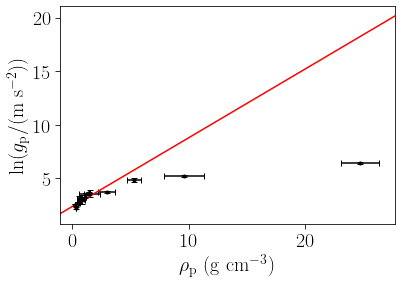

In [15]:
iteri = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x_data = plotData[:,indX,0]
        y_data = plotData[:,indY,0]
        x_sigma = np.abs(plotData[:,indX,1])
        y_sigma = np.abs(plotData[:,indY,1])

        r = pearsonr(x_data,y_data)
        if r[1]<0.05:
            iteri +=1
            if iteri in [0]:
                continue
            
            print(iteri)
            print(r)
            
            polyVars = np.polyfit(x_data, y_data, 1)
            
            params = []
            param_errs = []
            for i in tqdm(range(10001)):
                if i==0:
                    x_temp=x_data
                    y_temp=y_data
                    sx_temp=x_sigma
                    sy_temp=y_sigma
                else:
                    x_temp=np.random.normal(x_data, x_sigma)
                    y_temp=np.random.normal(y_data, y_sigma)
                    sx_temp=x_sigma
                    sy_temp=y_sigma
                data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
                def swapped(a,b):
                    return func(b,*a)
                func      = linear
                model = scipy.odr.Model(swapped)

                p_guess   = tuple(polyVars[::-1])
                fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

                output = fitted.run()
                p   = output.beta
                cov = output.cov_beta
                quasi_chisq = output.res_var
                uncertainty = output.sd_beta
                if quasi_chisq < 1.0 :
                    uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
                if False: # debugging print statements
                    print("sd_beta",output.sd_beta)
                    print("cov_beta",output.cov_beta)
                    print("delta",output.delta)
                    print("epsilon",output.epsilon)
                    print("res_var",output.res_var)
                    print("rel_error",output.rel_error)

                if i==0:
                    print("**** ODR has finished with: " + output.stopreason[0])
                    for j in range(len(p)) :
                        print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                               "          Guessed: {3:<10.5g}").
                                format(j,p[j],uncertainty[j],p_guess[j]))

                params.append(p)
                param_errs.append(uncertainty)
            params = np.array(params)
            param_errs = np.array(param_errs)

            print("**** MC uncertainty finding has finished")
            for j in range(len(p)) :
                print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                       "          Guessed: {3:<10.5g}").
                        format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))
                bias             = np.median(params[1:,j])/params[0,j]-1
                sorted_p_i = numpy.sort(params)[:,j]
                # Note: Am using Gaussian approximation for median uncertainty
                bias_uncertainty = (abs((param_errs[0,j]/params[0,j]))
                                        / numpy.sqrt(params.shape[0]-1-1)
                                        * numpy.sqrt(numpy.pi/2))
                print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
                      .format(j, bias, bias_uncertainty, bias/bias_uncertainty) )

            plt.errorbar(x_data, y_data, xerr=x_sigma, yerr=y_sigma, fmt='.', capsize=3, color='black')
            xlim = plt.gca().get_xlim()

            polyVars = [*np.median(params[1:], axis=0)[::-1]]
            x_smooth = np.linspace(xlim[0], xlim[1], 100)
            y_smooth = np.polyval(polyVars, x_smooth)
            plt.plot(x_smooth, y_smooth, '-', c='r')

            plt.xlim(*xlim)
            plt.ylabel(nameY)
            plt.xlabel(nameX)
            plt.show()

(-0.3546721734766951, 0.16245238814378787)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.45968 +/-    0.05173          Guessed: 0.19883   
   p[1] =    -0.2038 +/-   0.080314          Guessed: -0.024064 


100%|██████████| 10001/10001 [00:09<00:00, 1076.74it/s]


**** MC uncertainty finding has finished
   p[0] =    0.45741 +/-   0.045749          Guessed: 0.19883   
   p[0] Bias : -0.004929 +/- 0.001411  (  -3.49 SD)
   p[1] =   -0.20168 +/-   0.095458          Guessed: -0.024064 
   p[1] Bias : -0.01041  +/- 0.004939  (  -2.11 SD)


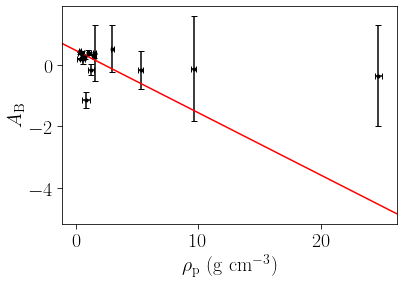

In [16]:
indX = 7
indY = -5

nameX = labels[indY]
nameY = labels[indX]

x_data = plotData[:,indY,0]
y_data = plotData[:,indX,0]

x_sigma = plotData[:,indX,1]
y_sigma = plotData[:,indY,1]

r = pearsonr(x_data,y_data)
print(r)

polyVars = np.polyfit(x_data, y_data, 1)
            
params = []
param_errs = []
for i in tqdm(range(10001)):
    if i==0:
        x_temp=x_data
        y_temp=y_data
        sx_temp=x_sigma
        sy_temp=y_sigma
    else:
        x_temp=np.random.normal(x_data, x_sigma)
        y_temp=np.random.normal(y_data, y_sigma)
        sx_temp=x_sigma
        sy_temp=y_sigma
    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
    def swapped(a,b):
        return func(b,*a)
    func      = linear
    model = scipy.odr.Model(swapped)

    p_guess   = tuple(polyVars[::-1])
    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

    output = fitted.run()
    p   = output.beta
    cov = output.cov_beta
    quasi_chisq = output.res_var
    uncertainty = output.sd_beta
    if quasi_chisq < 1.0 :
        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
    if False: # debugging print statements
        print("sd_beta",output.sd_beta)
        print("cov_beta",output.cov_beta)
        print("delta",output.delta)
        print("epsilon",output.epsilon)
        print("res_var",output.res_var)
        print("rel_error",output.rel_error)

    if i==0:
        print("**** ODR has finished with: " + output.stopreason[0])
        for j in range(len(p)) :
            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                   "          Guessed: {3:<10.5g}").
                    format(j,p[j],uncertainty[j],p_guess[j]))

    params.append(p)
    param_errs.append(uncertainty)
params = np.array(params)
param_errs = np.array(param_errs)

print("**** MC uncertainty finding has finished")
for j in range(len(p)) :
    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
           "          Guessed: {3:<10.5g}").
            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))
    bias             = np.median(params[1:,j])/params[0,j]-1
    sorted_p_i = numpy.sort(params)[:,j]
    # Note: Am using Gaussian approximation for median uncertainty
    bias_uncertainty = (abs((param_errs[0,j]/params[0,j]))
                            / numpy.sqrt(params.shape[0]-1-1)
                            * numpy.sqrt(numpy.pi/2))
    print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
          .format(j, bias, bias_uncertainty, bias/bias_uncertainty) )

plt.errorbar(x_data, y_data, xerr=x_sigma, yerr=y_sigma, fmt='.', capsize=3, color='black')
xlim = plt.gca().get_xlim()

polyVars = [*np.median(params[1:], axis=0)[::-1]]
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')

plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

In [17]:
for indY in [9,10,11,12]:
    indX = 7

    nameX = labels[indX]
    nameY = labels[indY]

    x_data = plotData[:,indX,0]
    y_data = plotData[:,indY,0]
    r = pearsonr(x_data,y_data)

    print(nameX, nameY)
    print(r)
    print()

$A_{\rm B}$ $M_{\rm p}~\rm (M_{\rm Jup})$
(-0.39002918284892574, 0.1216979310031802)

$A_{\rm B}$ $\ln(M_{\rm p}/M_{\rm Jup})$
(-0.44067457852656916, 0.07665086762526994)

$A_{\rm B}$ $\rho_{\rm p}~\rm (g~cm^{-3})$
(-0.3546721734766951, 0.16245238814378787)

$A_{\rm B}$ $\ln(g_{\rm p} / ({\rm m~s^{-2}}))$
(-0.38203098451572387, 0.13021401030048155)



In [18]:
import emcee
def loglike(polyVars, x, y, yerr):
    #slope, inter = polyVars
    slope = polyVars
    return -0.5*np.sum((y-slope*x)**2/yerr**2)

6


100%|██████████| 100000/100000 [01:09<00:00, 1430.95it/s]


Mean acceptance fraction: 0.807
0.8162519505368044 0.010408575377945914
[0.8162519505368044, 0]


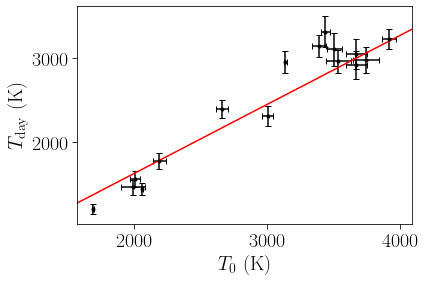

In [19]:
i = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            i +=1
            if i in [0]:#,1,2,3,4,5]:
                continue
            
            if i==6:
            
                print(i)
                
                x = x[planets!='KELT-9b']
                y = y[planets!='KELT-9b']
                xerr = xerr[planets!='KELT-9b']
                yerr = yerr[planets!='KELT-9b']

                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

                def line(polyVars, x, y):
                    #slope, inter = polyVars
                    slope = polyVars
                    return np.mean((y-slope*x)**2)
                
                xlim = plt.gca().get_xlim()
#                 polyVars = np.polyfit(x, y, 1)
#                 polyVars = scipy.optimize.minimize(line, [1,], args=(x,y), method='Nelder-Mead').x
                
                junkier = 1
                
                nwalkers = 20
                pos0 = np.random.normal(1,0.1,(nwalkers,1))
                sampler = emcee.EnsembleSampler(nwalkers, 1, loglike, args=(x,y,yerr), a = 2)
                pos2, prob, state = sampler.run_mcmc(pos0, 1e5, progress=True)
                print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

                print(np.median(sampler.flatchain), np.std(sampler.flatchain))
                
                polyVars = [np.median(sampler.flatchain),0]
                
#                 polyVars = [polyVars[0],0]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                print(polyVars)

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

6


  0%|          | 0/100001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.81756 +/-   0.020005          Guessed: 0.8       


100%|██████████| 100001/100001 [00:25<00:00, 3862.65it/s]


**** MC uncertainty finding has finished
   p[0] =    0.81755 +/-   0.010937          Guessed: 0.8       
   p[0] Bias : -1.425e-05 +/- 9.698e-05 (  -0.15 SD)


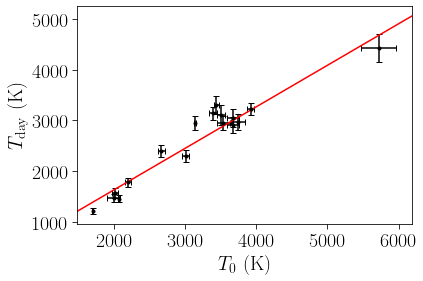

In [20]:
iteri = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            iteri +=1
            if iteri in [0]:#,1,2,3,4,5]:
                continue
            
            if iteri==6:
            
                print(iteri)

                x_data = x[planets!='KELT-9b']
                x_sigma = xerr[planets!='KELT-9b']
                y_data = y[planets!='KELT-9b']
                y_sigma = yerr[planets!='KELT-9b']
                
                params = []
                param_errs = []
                for i in tqdm(range(100001)):
                    if i==0:
                        x_temp=x_data
                        y_temp=y_data
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    else:
                        x_temp=np.random.normal(x_data, x_sigma)
                        y_temp=np.random.normal(y_data, y_sigma)
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
                    def swapped(a,b):
                        return func(b,*a)
                    func      = slope
                    model = scipy.odr.Model(swapped)

                    p_guess   = (0.8,)
                    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

                    output = fitted.run()
                    p   = output.beta
                    cov = output.cov_beta
                    quasi_chisq = output.res_var
                    uncertainty = output.sd_beta
                    if quasi_chisq < 1.0 :
                        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
                    if False: # debugging print statements
                        print("sd_beta",output.sd_beta)
                        print("cov_beta",output.cov_beta)
                        print("delta",output.delta)
                        print("epsilon",output.epsilon)
                        print("res_var",output.res_var)
                        print("rel_error",output.rel_error)

                    if i==0:
                        print("**** ODR has finished with: " + output.stopreason[0])
                        for j in range(len(p)) :
                            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                                   "          Guessed: {3:<10.5g}").
                                    format(j,p[j],uncertainty[j],p_guess[j]))
                    
                    params.append(p)
                    param_errs.append(uncertainty)
                params = np.array(params)
                param_errs = np.array(param_errs)

                print("**** MC uncertainty finding has finished")
                for j in range(len(p)) :
                    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                           "          Guessed: {3:<10.5g}").
                            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))

                bias             = np.median(params[1:])/params[0][0]-1
                sorted_p_i = numpy.sort(params)[:,0]
                # Note: Am using Gaussian approximation for median uncertainty
                bias_uncertainty = (abs((param_errs[0][0]/params[0][0]))
                                        / numpy.sqrt(params.shape[0]-1-1)
                                        * numpy.sqrt(numpy.pi/2))
                print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
                      .format( 0, bias, bias_uncertainty, bias/bias_uncertainty) )

                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')
                xlim = plt.gca().get_xlim()

                polyVars = [np.median(params[1:,0]),0]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

In [21]:
# OG MCMC: 0.8353049854841166 +/- 0.010060517041312684

7


100%|██████████| 100000/100000 [01:09<00:00, 1437.51it/s]


Mean acceptance fraction: 0.806
0.4186098162945426 0.012088123597848265
[0.4186098162945426, 0]


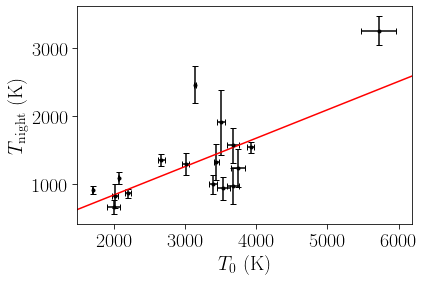

In [22]:
i = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            i +=1
            if i in [0]:#,1,2,3,4,5]:
                continue
            
            if i==7:
            
                print(i)

                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')
                
                x = x[planets!='KELT-9b']
                y = y[planets!='KELT-9b']
                xerr = xerr[planets!='KELT-9b']
                yerr = yerr[planets!='KELT-9b']
                
                def line(polyVars, x, y):
                    #slope, inter = polyVars
                    slope = polyVars
                    return np.mean((y-slope*x)**2)
                
                xlim = plt.gca().get_xlim()
#                 polyVars = np.polyfit(x, y, 1)
#                 polyVars = scipy.optimize.minimize(line, [1,], args=(x,y), method='Nelder-Mead').x
                
                junkier = 1
                
                nwalkers = 20
                pos0 = np.random.normal(1,0.1,(nwalkers,1))
                sampler = emcee.EnsembleSampler(nwalkers, 1, loglike, args=(x,y,yerr), a = 2)
                pos2, prob, state = sampler.run_mcmc(pos0, 1e5, progress=True)
                print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

                print(np.median(sampler.flatchain), np.std(sampler.flatchain))
                
                polyVars = [np.median(sampler.flatchain),0]
                
#                 polyVars = [polyVars[0],0]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                print(polyVars)

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

7


  0%|          | 0/100001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.42071 +/-   0.024671          Guessed: 0.4       


100%|██████████| 100001/100001 [00:24<00:00, 4129.11it/s]


**** MC uncertainty finding has finished
   p[0] =     0.4207 +/-   0.011145          Guessed: 0.4       
   p[0] Bias : -1.868e-05 +/- 0.0002324 (  -0.08 SD)


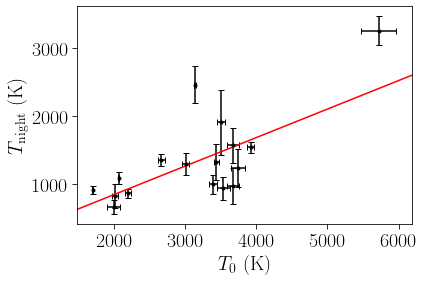

In [23]:
iteri = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            iteri +=1
            if iteri in [0]:#,1,2,3,4,5]:
                continue
            
            if iteri==7:
            
                print(iteri)

                x_data = x[planets!='KELT-9b']
                x_sigma = xerr[planets!='KELT-9b']
                y_data = y[planets!='KELT-9b']
                y_sigma = yerr[planets!='KELT-9b']
                
                params = []
                param_errs = []
                for i in tqdm(range(100001)):
                    if i==0:
                        x_temp=x_data
                        y_temp=y_data
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    else:
                        x_temp=np.random.normal(x_data, x_sigma)
                        y_temp=np.random.normal(y_data, y_sigma)
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
                    def swapped(a,b):
                        return func(b,*a)
                    func      = slope
                    model = scipy.odr.Model(swapped)

                    p_guess   = (0.4,)
                    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

                    output = fitted.run()
                    p   = output.beta
                    cov = output.cov_beta
                    quasi_chisq = output.res_var
                    uncertainty = output.sd_beta
                    if quasi_chisq < 1.0 :
                        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
                    if False: # debugging print statements
                        print("sd_beta",output.sd_beta)
                        print("cov_beta",output.cov_beta)
                        print("delta",output.delta)
                        print("epsilon",output.epsilon)
                        print("res_var",output.res_var)
                        print("rel_error",output.rel_error)

                    if i==0:
                        print("**** ODR has finished with: " + output.stopreason[0])
                        for j in range(len(p)) :
                            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                                   "          Guessed: {3:<10.5g}").
                                    format(j,p[j],uncertainty[j],p_guess[j]))
                    
                    params.append(p)
                    param_errs.append(uncertainty)
                params = np.array(params)
                param_errs = np.array(param_errs)

                print("**** MC uncertainty finding has finished")
                for j in range(len(p)) :
                    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                           "          Guessed: {3:<10.5g}").
                            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))

                bias             = np.median(params[1:])/params[0][0]-1
                sorted_p_i = numpy.sort(params)[:,0]
                # Note: Am using Gaussian approximation for median uncertainty
                bias_uncertainty = (abs((param_errs[0][0]/params[0][0]))
                                        / numpy.sqrt(params.shape[0]-1-1)
                                        * numpy.sqrt(numpy.pi/2))
                print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
                      .format( 0, bias, bias_uncertainty, bias/bias_uncertainty) )

                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')
                xlim = plt.gca().get_xlim()

                polyVars = [np.median(params[1:,0]),0]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

In [24]:
# OG MCMC: 0.4185670741189461 +/- 0.0113442685793971

(-0.19612058332691948, 0.450605698328185)
1


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.89572 +/-   0.024503          Guessed: 0.9       
   p[1] =  -0.006023 +/-  0.0011568          Guessed: -0.004    


100%|██████████| 10001/10001 [00:04<00:00, 2105.98it/s]


**** MC uncertainty finding has finished
   p[0] =    0.89569 +/-    0.01165          Guessed: 0.9       
   p[0] Bias : -3.048e-05 +/- 0.0003429 (  -0.09 SD)
   p[1] = -0.0060195 +/- 0.00059344          Guessed: -0.004    
   p[1] Bias : -0.0005719 +/- 0.002407  (  -0.24 SD)


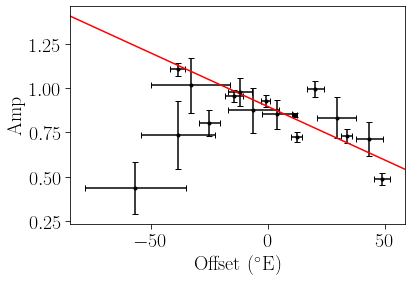

In [25]:
iteri = 0
for indX in [5,]:
    nameX = labels[indX]
    for indY in [15,]:
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        print(r)
        if True:#r[1]<0.05:
            iteri +=1
            if iteri in [0]:#,1,2,3,4,5]:
                continue
            
            if True:#iteri==22:
            
                print(iteri)

                x_data = x
                x_sigma = xerr
                y_data = y
                y_sigma = yerr
                
                params = []
                param_errs = []
                for i in tqdm(range(10001)):
                    if i==0:
                        x_temp=x_data
                        y_temp=y_data
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    else:
                        x_temp=np.random.normal(x_data, x_sigma)
                        y_temp=np.random.normal(y_data, y_sigma)
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
                    def swapped(a,b):
                        return func(b,*a)
                    func      = linear
                    model = scipy.odr.Model(swapped)

                    p_guess   = (0.9, -0.004)
                    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

                    output = fitted.run()
                    p   = output.beta
                    cov = output.cov_beta
                    quasi_chisq = output.res_var
                    uncertainty = output.sd_beta
                    if quasi_chisq < 1.0 :
                        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
                    if False: # debugging print statements
                        print("sd_beta",output.sd_beta)
                        print("cov_beta",output.cov_beta)
                        print("delta",output.delta)
                        print("epsilon",output.epsilon)
                        print("res_var",output.res_var)
                        print("rel_error",output.rel_error)

                    if i==0:
                        print("**** ODR has finished with: " + output.stopreason[0])
                        for j in range(len(p)) :
                            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                                   "          Guessed: {3:<10.5g}").
                                    format(j,p[j],uncertainty[j],p_guess[j]))
                    
                    params.append(p)
                    param_errs.append(uncertainty)
                params = np.array(params)
                param_errs = np.array(param_errs)

                print("**** MC uncertainty finding has finished")
                for j in range(len(p)) :
                    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                           "          Guessed: {3:<10.5g}").
                            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))
                    bias             = np.median(params[1:,j])/params[0,j]-1
                    sorted_p_i = numpy.sort(params)[:,j]
                    # Note: Am using Gaussian approximation for median uncertainty
                    bias_uncertainty = (abs((param_errs[0,j]/params[0,j]))
                                            / numpy.sqrt(params.shape[0]-1-1)
                                            * numpy.sqrt(numpy.pi/2))
                    print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
                          .format(j, bias, bias_uncertainty, bias/bias_uncertainty) )

                plt.errorbar(x_data, y_data, xerr=x_sigma, yerr=y_sigma, fmt='.', capsize=3, color='black')
                xlim = plt.gca().get_xlim()

                polyVars = [*np.median(params[1:], axis=0)[::-1]]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

1
(-0.5529082014552926, 0.021335759687304157)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.97586 +/-   0.055428          Guessed: 0.9       
   p[1] = -0.0081508 +/-  0.0027101          Guessed: -0.004    


100%|██████████| 10001/10001 [00:08<00:00, 1230.54it/s]


**** MC uncertainty finding has finished
   p[0] =    0.97595 +/-    0.02709          Guessed: 0.9       
   p[0] Bias : +8.832e-05 +/- 0.0007119 (   0.12 SD)
   p[1] =   -0.00816 +/-  0.0015255          Guessed: -0.004    
   p[1] Bias : +0.001122 +/- 0.004167  (   0.27 SD)


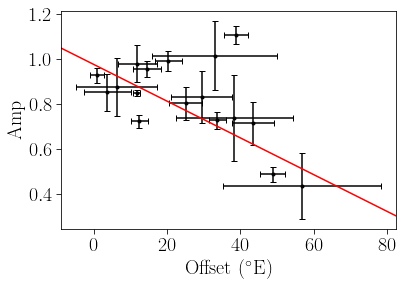

In [26]:
iteri = 0
for indX in [5,]:
    nameX = labels[indX]
    for indY in [15,]:
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        
        if True:#r[1]<0.05:
            iteri +=1
            if iteri in [0]:#,1,2,3,4,5]:
                continue
            
            if True:#iteri==22:
            
                print(iteri)

                x_data = np.abs(x)
                x_sigma = xerr
                y_data = y
                y_sigma = yerr
                
                r = pearsonr(x_data,y_data)
                print(r)
                
                params = []
                param_errs = []
                for i in tqdm(range(10001)):
                    if i==0:
                        x_temp=x_data
                        y_temp=y_data
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    else:
                        x_temp=np.random.normal(x_data, x_sigma)
                        y_temp=np.random.normal(y_data, y_sigma)
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
                    def swapped(a,b):
                        return func(b,*a)
                    func      = linear
                    model = scipy.odr.Model(swapped)

                    p_guess   = (0.9, -0.004)
                    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

                    output = fitted.run()
                    p   = output.beta
                    cov = output.cov_beta
                    quasi_chisq = output.res_var
                    uncertainty = output.sd_beta
                    if quasi_chisq < 1.0 :
                        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
                    if False: # debugging print statements
                        print("sd_beta",output.sd_beta)
                        print("cov_beta",output.cov_beta)
                        print("delta",output.delta)
                        print("epsilon",output.epsilon)
                        print("res_var",output.res_var)
                        print("rel_error",output.rel_error)

                    if i==0:
                        print("**** ODR has finished with: " + output.stopreason[0])
                        for j in range(len(p)) :
                            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                                   "          Guessed: {3:<10.5g}").
                                    format(j,p[j],uncertainty[j],p_guess[j]))
                    
                    params.append(p)
                    param_errs.append(uncertainty)
                params = np.array(params)
                param_errs = np.array(param_errs)

                print("**** MC uncertainty finding has finished")
                for j in range(len(p)) :
                    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                           "          Guessed: {3:<10.5g}").
                            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))
                    bias             = np.median(params[1:,j])/params[0,j]-1
                    sorted_p_i = numpy.sort(params)[:,j]
                    # Note: Am using Gaussian approximation for median uncertainty
                    bias_uncertainty = (abs((param_errs[0,j]/params[0,j]))
                                            / numpy.sqrt(params.shape[0]-1-1)
                                            * numpy.sqrt(numpy.pi/2))
                    print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
                          .format(j, bias, bias_uncertainty, bias/bias_uncertainty) )

                plt.errorbar(x_data, y_data, xerr=x_sigma, yerr=y_sigma, fmt='.', capsize=3, color='black')
                xlim = plt.gca().get_xlim()

                polyVars = [*np.median(params[1:], axis=0)[::-1]]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

In [28]:
print('&', ' & '.join(labels)+' \\\\')
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    string = nameX+' & '
    for indY_temp in range(plotData.shape[1]):
        indY = indY_temp
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        
        string += format(np.round(r[0], 2), '0.2f')+' & '
    string = string[:-3]+' \\\\'
    print(string)

& $T_{\rm *}~\rm (K)$ & $T_{\rm 0}~\rm (K)$ & $T_{\rm day}~\rm (K)$ & $T_{\rm night}~\rm (K)$ & $A$ & $\rm Offset~\rm (^{\circ}E)$ & $\epsilon$ & $A_{\rm B}$ & $R_{\rm p}~(R_{\rm Jup})$ & $M_{\rm p}~\rm (M_{\rm Jup})$ & $\ln(M_{\rm p}/M_{\rm Jup})$ & $\rho_{\rm p}~\rm (g~cm^{-3})$ & $\ln(g_{\rm p} / ({\rm m~s^{-2}}))$ & $P~\rm (days)$ & $\rm [Fe/H]_{\rm *}$ & $\rm Amp$ \\
$T_{\rm *}~\rm (K)$ & 1.00 & 0.90 & 0.84 & 0.79 & -0.43 & 0.24 & 0.18 & -0.17 & 0.67 & 0.11 & 0.26 & 0.00 & 0.00 & 0.06 & -0.15 & -0.54 \\
$T_{\rm 0}~\rm (K)$ & 0.90 & 1.00 & 0.97 & 0.75 & -0.26 & 0.05 & -0.05 & -0.19 & 0.69 & 0.11 & 0.24 & 0.03 & -0.02 & -0.33 & 0.06 & -0.39 \\
$T_{\rm day}~\rm (K)$ & 0.84 & 0.97 & 1.00 & 0.72 & -0.24 & -0.06 & -0.09 & -0.37 & 0.60 & 0.25 & 0.40 & 0.17 & 0.14 & -0.36 & 0.06 & -0.35 \\
$T_{\rm night}~\rm (K)$ & 0.79 & 0.75 & 0.72 & 1.00 & -0.80 & 0.06 & 0.58 & -0.50 & 0.61 & -0.09 & 0.01 & -0.17 & -0.19 & 0.05 & 0.06 & -0.80 \\
$A$ & -0.43 & -0.26 & -0.24 & -0.80 & 1.00 & -0.13 & -0.9

In [29]:
''.join(['c|' for label in labels])

'c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|'

In [30]:
junk = '''979±58 979±58 1015±86 792±64 1098±201 1267±111 986±233 1507±285 1128±108 815±463 1528±108 1256±386 1776±165'''.split(' ')
junk = np.array([junk[i].split('±') for i in range(len(junk))]).astype(float)

100%|██████████| 10000/10000 [00:08<00:00, 1157.55it/s]


Mean acceptance fraction: 0.807
0.4405557251305432 0.0226116076533632
[0.4405557251305432, 0]


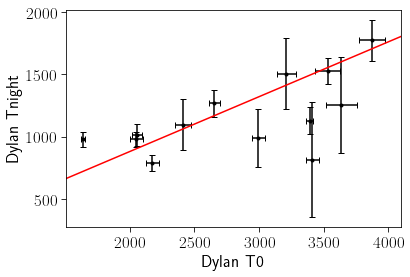

In [31]:
x = [1636,2051,2053,2175,2411, 2654,2995, 3211,3391,3412,3530,3636,3874]
y = junk[:,0]
xerr = [14,53,38,47,59,43,52,75,29,49,99,121,104]
yerr = junk[:,1]

r = pearsonr(x,y)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

def line(polyVars, x, y):
    #slope, inter = polyVars
    slope = polyVars
    return np.mean((y-slope*x)**2)

xlim = plt.gca().get_xlim()
# polyVars = np.polyfit(x, y, 1)
# polyVars = scipy.optimize.minimize(line, [1,], args=(x,y), method='Nelder-Mead').x

junkier = 1

nwalkers = 20
pos0 = np.random.normal(1,0.1,(nwalkers,1))
sampler = emcee.EnsembleSampler(nwalkers, 1, loglike, args=(x,y,yerr), a = 2)
pos2, prob, state = sampler.run_mcmc(pos0, 1e4, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

print(np.median(sampler.flatchain), np.std(sampler.flatchain))

polyVars = [np.median(sampler.flatchain),0]

# polyVars = [polyVars[0],0]
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')

print(polyVars)

plt.xlim(*xlim)
plt.ylabel('Dylan Tnight')
plt.xlabel('Dylan T0')
plt.show()

  0%|          | 0/100001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.44088 +/-   0.023485          Guessed: 0.8       


100%|██████████| 100001/100001 [00:26<00:00, 3829.81it/s]


**** MC uncertainty finding has finished
   p[0] =    0.44096 +/-   0.012001          Guessed: 0.8       
   p[0] Bias : +0.0001756 +/- 0.0006676 (   0.26 SD)


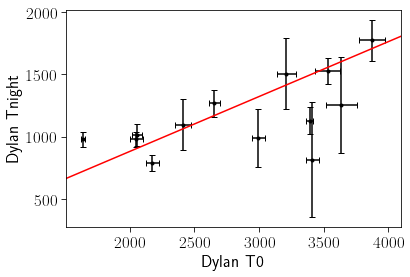

In [32]:
params = []
param_errs = []
for i in tqdm(range(100001)):
    if i==0:
        x_temp=x
        y_temp=y
        sx_temp=xerr
        sy_temp=yerr
    else:
        x_temp=np.random.normal(x, xerr)
        y_temp=np.random.normal(y, yerr)
        sx_temp=xerr
        sy_temp=yerr
    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
    def swapped(a,b):
        return func(b,*a)
    func      = slope
    model = scipy.odr.Model(swapped)

    p_guess   = (0.8,)
    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

    output = fitted.run()
    p   = output.beta
    cov = output.cov_beta
    quasi_chisq = output.res_var
    uncertainty = output.sd_beta
    if quasi_chisq < 1.0 :
        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
    if False: # debugging print statements
        print("sd_beta",output.sd_beta)
        print("cov_beta",output.cov_beta)
        print("delta",output.delta)
        print("epsilon",output.epsilon)
        print("res_var",output.res_var)
        print("rel_error",output.rel_error)

    if i==0:
        print("**** ODR has finished with: " + output.stopreason[0])
        for j in range(len(p)) :
            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                   "          Guessed: {3:<10.5g}").
                    format(j,p[j],uncertainty[j],p_guess[j]))

    params.append(p)
    param_errs.append(uncertainty)
params = np.array(params)
param_errs = np.array(param_errs)

print("**** MC uncertainty finding has finished")
for j in range(len(p)) :
    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
           "          Guessed: {3:<10.5g}").
            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))

bias             = np.median(params[1:])/params[0][0]-1
sorted_p_i = numpy.sort(params)[:,0]
# Note: Am using Gaussian approximation for median uncertainty
bias_uncertainty = (abs((param_errs[0][0]/params[0][0]))
                        / numpy.sqrt(10000-1)
                        * numpy.sqrt(numpy.pi/2))
print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
      .format( 0, bias, bias_uncertainty, bias/bias_uncertainty) )

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')
xlim = plt.gca().get_xlim()

polyVars = [np.median(params[1:,0]),0]
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')

plt.xlim(*xlim)
plt.ylabel('Dylan Tnight')
plt.xlabel('Dylan T0')
plt.show()

In [33]:
# OG MCMC: 0.44030884007307486 +/- 0.02124792665766911

In [34]:
import emcee
import scipy
def loglike(polyVars, x, y, yerr):
    model = line(polyVars, x, y)
    return -0.5*np.sum((y-model)**2/yerr**2)

def neg_loglike(polyVars, x, y, yerr):
    return -loglike(polyVars, x, y, yerr)

def line(polyVars, x, y):
    if len(polyVars)==2:
        slope, inter = polyVars
    else:
        slope = polyVars
        inter = 0
    return slope*x+inter

100%|██████████| 100000/100000 [01:26<00:00, 1158.53it/s]


Mean acceptance fraction: 0.715
[-0.2025948   0.25534415] [0.35822942 0.04599059]
[-0.2025948   0.25534415]


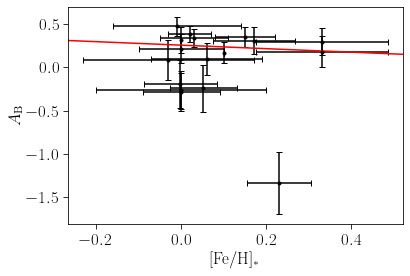

In [35]:
indX = -2
indY = -9

nameX = labels[indX]
nameY = labels[indY]

x = plotData[:,indX,0]
y = plotData[:,indY,0]
xerr = plotData[:,indX,1]
yerr = plotData[:,indY,1]

r = pearsonr(x,y)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

# polyVars = np.polyfit(x, y, 1)
# polyVars = scipy.optimize.minimize(neg_loglike, [1,0], args=(x,y,yerr), method='Nelder-Mead').x

nwalkers = 20
ndim = 2
pos0 = np.random.normal(1,0.1,(nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=(x,y,yerr), a = 2)
pos2, prob, state = sampler.run_mcmc(pos0, 1e5, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

print(np.median(sampler.flatchain, axis=0), np.std(sampler.flatchain, axis=0))

polyVars = np.median(sampler.flatchain, axis=0)
# polyVars = [np.median(sampler.flatchain),0]
# polyVars = [polyVars[0],0]
print(polyVars)

xlim = plt.gca().get_xlim()
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')
plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

In [ ]:
params = []
param_errs = []
for i in tqdm(range(100001)):
    if i==0:
        x_temp=x
        y_temp=y
        sx_temp=xerr
        sy_temp=yerr
    else:
        x_temp=np.random.normal(x, xerr)
        y_temp=np.random.normal(y, yerr)
        sx_temp=xerr
        sy_temp=yerr
    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
    def swapped(a,b):
        return func(b,*a)
    func      = linear
    model = scipy.odr.Model(swapped)

    p_guess   = (-0.02382594, 0.07991733)
    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

    output = fitted.run()
    p   = output.beta
    cov = output.cov_beta
    quasi_chisq = output.res_var
    uncertainty = output.sd_beta
    if quasi_chisq < 1.0 :
        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
    if False: # debugging print statements
        print("sd_beta",output.sd_beta)
        print("cov_beta",output.cov_beta)
        print("delta",output.delta)
        print("epsilon",output.epsilon)
        print("res_var",output.res_var)
        print("rel_error",output.rel_error)

    if i==0:
        print("**** ODR has finished with: " + output.stopreason[0])
        for j in range(len(p)) :
            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                   "          Guessed: {3:<10.5g}").
                    format(j,p[j],uncertainty[j],p_guess[j]))

    params.append(p)
    param_errs.append(uncertainty)
params = np.array(params)
param_errs = np.array(param_errs)

print("**** MC uncertainty finding has finished")
for j in range(len(p)) :
    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
           "          Guessed: {3:<10.5g}").
            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))
    bias             = np.median(params[1:,j])/params[0,j]-1
    sorted_p_i = numpy.sort(params)[:,j]
    # Note: Am using Gaussian approximation for median uncertainty
    bias_uncertainty = (abs((param_errs[0,j]/params[0,j]))
                            / numpy.sqrt(params.shape[0]-1-1)
                            * numpy.sqrt(numpy.pi/2))
    print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
          .format(j, bias, bias_uncertainty, bias/bias_uncertainty) )

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')
xlim = plt.gca().get_xlim()

polyVars = [*np.median(params[1:], axis=0)[::-1]]
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')

plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

  0%|          | 0/100001 [00:00<?, ?it/s]

**** ODR has finished with: Numerical error detected
   p[0] =        nan +/-        nan          Guessed: -0.023826 
   p[1] =        nan +/-        nan          Guessed: 0.079917  


  2%|▏         | 1927/100001 [00:53<44:35, 36.65it/s]

In [ ]:
# OG MCMC: 0.07991733 +/- 0.02294573; -0.02382594 +/- 0.02855624

In [ ]:
indX = -2

nameY = r'$\rm Day$--$\rm Night~Temperature~Contrast$'
nameX = labels[indX]

x = plotData[:,indX,0]
y = (1-plotData[:,3,0]/plotData[:,2,0])
xerr = plotData[:,indX,1]
yerr = np.sqrt((plotData[:,3,1]/plotData[:,2,0])**2+(plotData[:,3,0]/plotData[:,2,0]**2*plotData[:,2,1])**2)#plotData[:,indY,1]

r = pearsonr(x,y)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

# polyVars = np.polyfit(x, y, 1)
polyVars = scipy.optimize.minimize(neg_loglike, [1,0], args=(x,y,yerr), method='Nelder-Mead').x

nwalkers = 20
ndim = 2
pos0 = polyVars*np.random.normal(1,0.1,(nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=(x,y,yerr), a = 2)
pos2, prob, state = sampler.run_mcmc(pos0, 1e4, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

print(np.median(sampler.flatchain, axis=0), np.std(sampler.flatchain, axis=0))

polyVars = np.median(sampler.flatchain, axis=0)
# polyVars = [np.median(sampler.flatchain),0]
# polyVars = [polyVars[0],0]
print(polyVars)

xlim = plt.gca().get_xlim()
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')
plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

In [ ]:
indX = 1

nameY = r'$\rm Day$--$\rm Night~Temperature~Contrast$'
nameX = labels[indX]

x = plotData[:,indX,0]
y = (1-plotData[:,3,0]/plotData[:,2,0])
xerr = plotData[:,indX,1]
yerr = np.sqrt((plotData[:,3,1]/plotData[:,2,0])**2+(plotData[:,3,0]/plotData[:,2,0]**2*plotData[:,2,1])**2)#plotData[:,indY,1]

r = pearsonr(x,y)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

# polyVars = np.polyfit(x, y, 1)
polyVars = scipy.optimize.minimize(neg_loglike, [1,0], args=(x,y,yerr), method='Nelder-Mead').x

nwalkers = 20
ndim = 2
pos0 = polyVars*np.random.normal(1,0.1,(nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=(x,y,yerr), a = 2)
pos2, prob, state = sampler.run_mcmc(pos0, 1e4, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

print(np.median(sampler.flatchain, axis=0), np.std(sampler.flatchain, axis=0))

polyVars = np.median(sampler.flatchain, axis=0)
# polyVars = [np.median(sampler.flatchain),0]
# polyVars = [polyVars[0],0]
print(polyVars)

xlim = plt.gca().get_xlim()
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')
plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

In [ ]:
planets[y<0.4]

In [ ]:
plotData[:,-2,0][y<0.4]

In [ ]:
planets[y<0.45]